In [250]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
import os
import seaborn as sns
import sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer, normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import confusion_matrix, accuracy_score, average_precision_score
from sklearn.metrics import precision_recall_curve, SCORERS
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import itertools
from sklearn.decomposition import PCA
from sklearn.tree import export_graphviz
from pandas.plotting import scatter_matrix
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import graphviz 
from sklearn.tree import export_graphviz
import statsmodels.api as stm
import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from treeinterpreter import treeinterpreter as ti
np.random.seed(11)

In [2]:
cwd = os.getcwd()
pitchers = pd.read_csv(cwd + ('/cleaned/fixed_complete_list.csv'))

In [3]:
#important features from models in modeling 
pitchers = pitchers.reindex(columns = ['Age', 'in_majors', 'lgID', 'weight',
       'height', 'throws', 'W', 'L', 'G', 'GS', 'IP', 'H', 'HR', 'BAOpp',
       'ERA', 'SF', 'GIDP', 'Balls', 'Strikes', 'Pitches', 'FB%', 'SL%', 'CT%',
       'CB%', 'CH%', 'num_pitches', 'avg_velo', 'previous', 'injured'])
pitchers = pitchers[pitchers['throws'] != 'S']
pitchers.replace({'no' : 0, 'yes' : 1, 'NL': 0, 'AL':1, 'R':0, 'L': 1}, inplace=True)
pitchers = pitchers.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

In [87]:
pitchers.head()

,Age,in_majors,lgID,weight,height,throws,W,L,G,GS,...,Strikes,Pitches,FB%,SL%,CT%,CB%,CH%,num_pitches,avg_velo,previous
0,0.266667,0.192308,1.0,0.37500,0.529412,0.0,0.125000,0.315789,0.791209,0.000000,...,0.293850,0.321827,0.869,0.076647,0.000000,0.000000,0.000000,0.428571,0.947320,1.0
1,0.433333,0.115385,1.0,0.09375,0.470588,0.0,0.000000,0.000000,0.010989,0.000000,...,0.028094,0.032234,0.547,0.458683,0.000000,0.000000,0.075350,0.428571,0.900041,0.0
2,0.433333,0.115385,1.0,0.09375,0.470588,0.0,0.000000,0.000000,0.021978,0.000000,...,0.028094,0.032234,0.547,0.458683,0.000000,0.000000,0.075350,0.428571,0.900041,0.0
3,0.266667,0.153846,1.0,0.25000,0.352941,0.0,0.000000,0.000000,0.274725,0.000000,...,0.102506,0.114467,0.551,0.088623,0.279443,0.000000,0.000000,0.571429,0.927858,1.0
4,0.233333,0.038462,1.0,0.31250,0.470588,0.0,0.416667,0.052632,0.461538,0.028571,...,0.315869,0.316497,0.430,0.000000,0.222698,0.246684,0.190527,0.571429,0.885266,1.0


In [4]:
def plot_roc_curve(fpr, tpr, model='ROC'):
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    print('AUC: {}'.format(metrics.auc(fpr, tpr)))
    plt.figure(figsize=(8,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve for ' + model)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    return

In [5]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' #'.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    true_negative  = cm[0,0]
    true_positive  = cm[1,1]
    false_negative = cm[1,0]
    false_positive = cm[0,1]
    total = true_negative + true_positive + false_negative + false_positive
    accuracy = (true_positive + true_negative)/total
    precision = (true_positive)/(true_positive + false_positive)
    recall = (true_positive)/(true_positive + false_negative)
    misclassification_rate = (false_positive + false_negative)/total
    F1 = (2*true_positive)/(2*true_positive + false_positive + false_negative)
    print('accuracy.................%7.4f' % accuracy)
    print('precision................%7.4f' % precision)
    print('recall...................%7.4f' % recall)
    print('F1.......................%7.4f' % F1)

In [6]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(20,20))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

In [7]:
# Model Parameter Grids Ranges

#Logistic Regression
param_grid1 = {'C': [0.001, 0.01] }

#Random Forest
param_grid2 = {"n_estimators": range(20, 100, 2),
                  "max_depth": range(4, 20, 2),
                  "min_samples_leaf": range(2, 100, 2),
                  "max_features": range(1, 100+1),
                  "min_samples_split": range(2, 10),
                  "bootstrap": [True],
                  "criterion": ["gini", "entropy"]}

#Gradient Boost
param_grid3 = {'n_estimators': [100],
                  'learning_rate':[0.1],
                  'max_depth': []}

#AdaBoost
param_grid5 = {"base_estimator__criterion" : ["gini", "entropy"],
                   'learning_rate':[0.001, 0.01],
                   "base_estimator__splitter" :   ["best", "random"],
                   "n_estimators": [1, 2]}

In [172]:
def grid_search(clf, param_grid):
    global best_model, saved_model
    cv = ShuffleSplit(n_splits = 15, test_size = 0.30, random_state = 2)
    n_iter_search = 70
    estimator = GridSearchCV(clf,
                                   param_grid = param_grid,
                                   scoring = 'roc_auc',
                                   verbose = 1,
                                   cv = cv,
                                   n_jobs = 3)
        
    fit = estimator.fit(X_train, i_train)
    
    best_model = estimator.best_estimator_
    print('\nbest_model:\n', best_model)

    print('\nFeature Importances:', plot_feature_importances(best_model))
    
    y_predicted = best_model.predict(X_train)
    probabilities = best_model.predict_proba(X_test)
    y_score = best_model.decision_function(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(i_test, y_score)
    
    plot_roc_curve(fpr, tpr)
    
    c_report = classification_report(i_train, y_predicted)
    print('\nClassification report:\n', c_report)
    return best_model, fit, probabilities, c_report

In [9]:
inj = pitchers.injured
pitchers.drop(columns= ["injured"], axis=1, inplace=True)

In [80]:
X_train, X_test, i_train, i_test = train_test_split(pitchers, inj, test_size = .3)

# Decision Tree

In [11]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 10) 
tree_clf.fit(X_train, i_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [12]:
tree_clf.score(X_train, i_train)

0.8380499896715554

In [13]:
tree_clf.score(X_test, i_test)

0.659277108433735

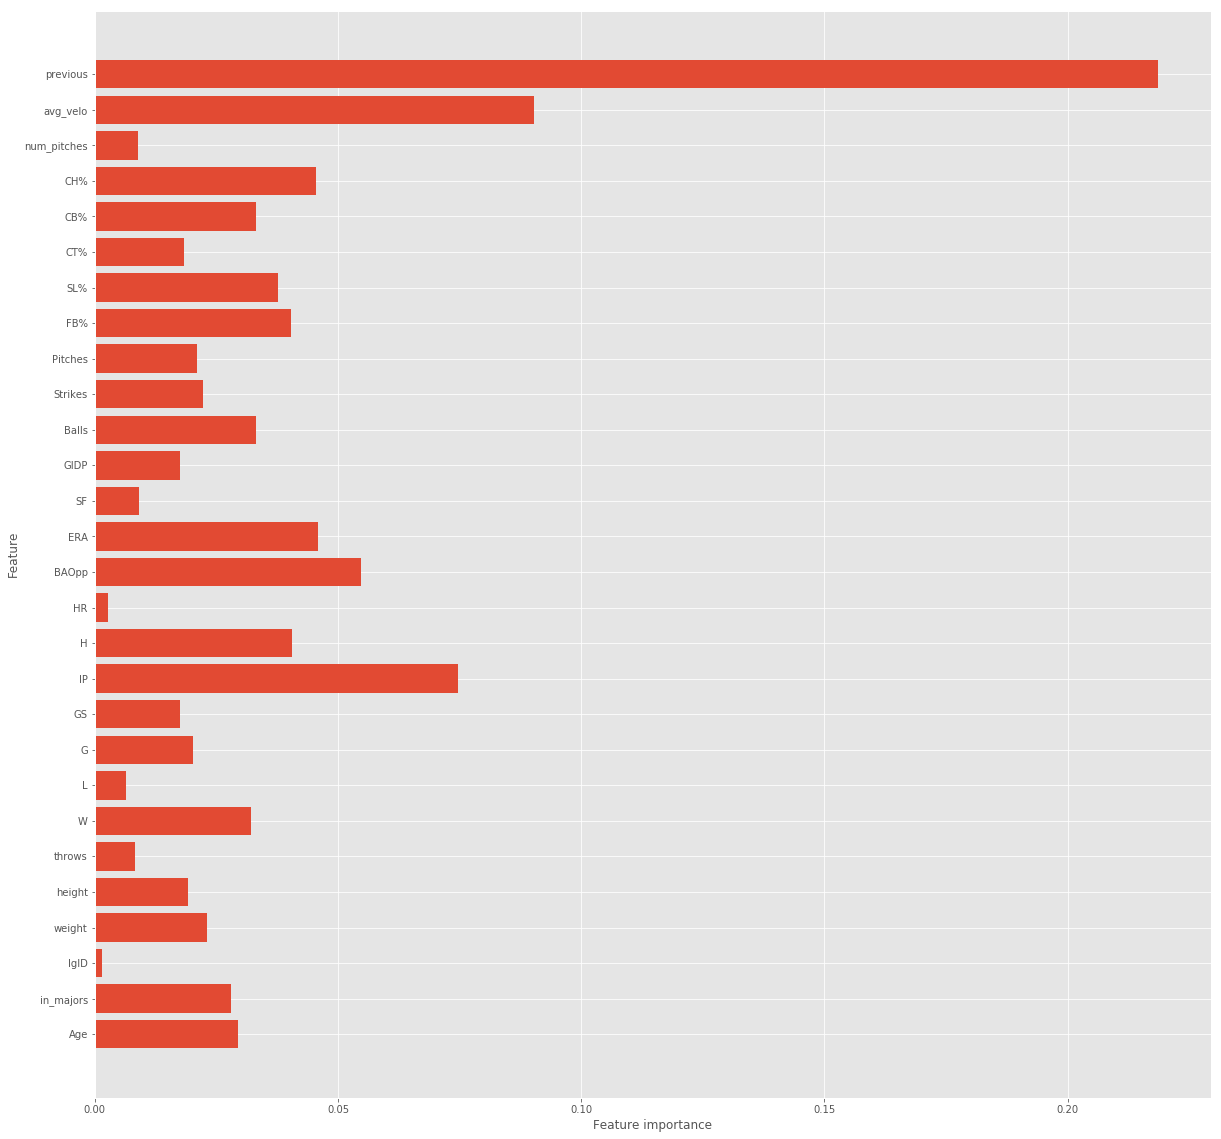

In [14]:
plot_feature_importances(tree_clf)

accuracy................. 0.6593
precision................ 0.5400
recall................... 0.5757
F1....................... 0.5573


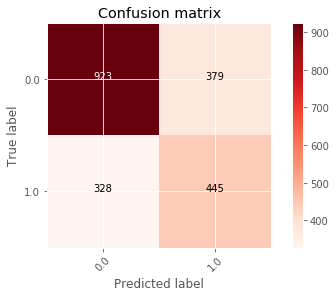

In [15]:
dtm= tree_clf.predict(X_test)
dtmtree = metrics.confusion_matrix(i_test, dtm)
plt.figure()
plot_confusion_matrix(dtmtree, classes=set(inj),
                      title='Confusion matrix')

plt.show()

In [98]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
tree_clf.fit(X_train, i_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [99]:
print(tree_clf.score(X_train, i_train))
tree_clf.score(X_test, i_test)

0.7091510018591201


0.6901204819277108

accuracy................. 0.6901
precision................ 0.5926
recall................... 0.6663
F1....................... 0.6272


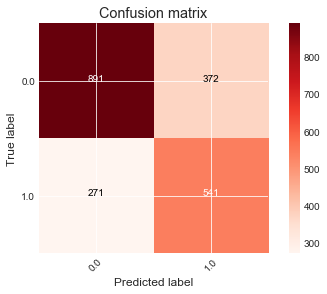

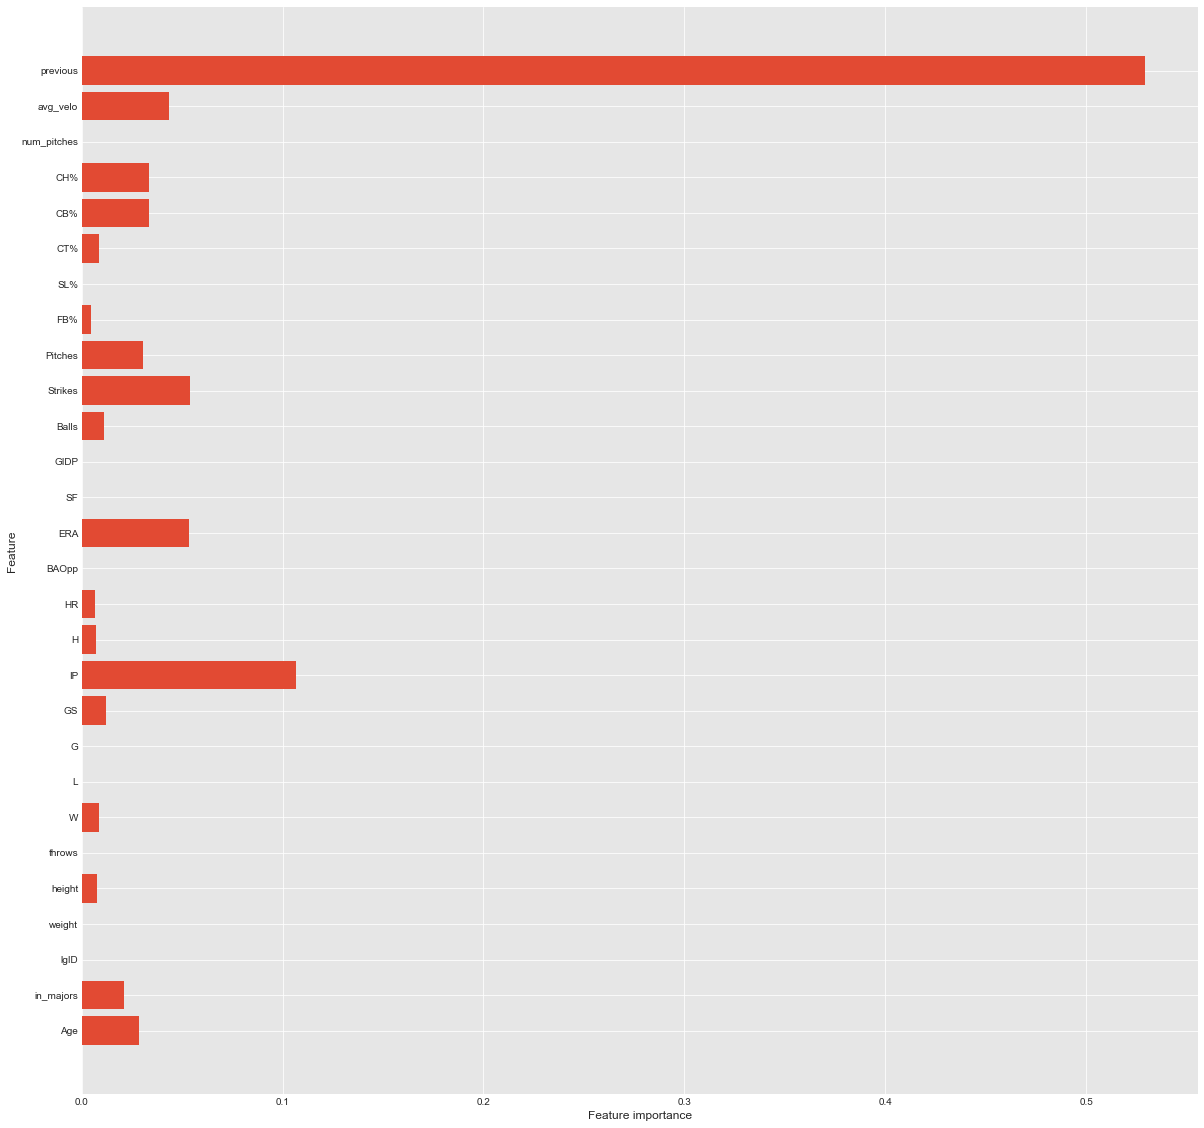

In [100]:
dtm= tree_clf.predict(X_test)
dtmtree = metrics.confusion_matrix(i_test, dtm)
plt.figure()
plot_confusion_matrix(dtmtree, classes=set(inj),
                      title='Confusion matrix')

plt.show()

plot_feature_importances(tree_clf)

In [239]:
rf = RandomForestClassifier()
rf_model = rf.fit(X_train, i_train)

prediction, bias, contributions = ti.predict(rf, X_test)


In [233]:
#sum of bias and feature
assert(np.allclose(prediction, bias + np.sum(contributions, axis=1)))
assert(np.allclose(rf.predict_proba(X_test), bias + np.sum(contributions, axis=1)))

In [234]:
rf.predict(X_test), bias + np.sum(contributions, axis=1)

(array([0., 1., 0., ..., 0., 0., 0.]), array([[9.00000000e-01, 1.00000000e-01],
        [4.00000000e-01, 6.00000000e-01],
        [1.00000000e+00, 5.55111512e-17],
        ...,
        [7.00000000e-01, 3.00000000e-01],
        [8.00000000e-01, 2.00000000e-01],
        [9.00000000e-01, 1.00000000e-01]]))

In [238]:
print ("Prediction", prediction)
print ("Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             pitch.columns):
    print (feature, c)

Prediction [[0.9 0.1]
 [0.4 0.6]
 [1.  0. ]
 ...
 [0.7 0.3]
 [0.8 0.2]
 [0.9 0.1]]
Bias (trainset prior) [[0.61706259 0.38293741]
 [0.61706259 0.38293741]
 [0.61706259 0.38293741]
 ...
 [0.61706259 0.38293741]
 [0.61706259 0.38293741]
 [0.61706259 0.38293741]]
Feature contributions:
Age [ 0.03151322 -0.03151322]
in_majors [-0.06348544  0.06348544]
weight [-0.01075459  0.01075459]
height [ 0.03452976 -0.03452976]
W [ 0.00361323 -0.00361323]
L [-0.01066177  0.01066177]
G [-0.03807302  0.03807302]
IP [ 0.05395463 -0.05395463]
H [ 0.00408467 -0.00408467]
HR [ 0.0243837 -0.0243837]
BAOpp [ 0.02689639 -0.02689639]
ERA [ 0.03559148 -0.03559148]
GIDP [ 0.00899667 -0.00899667]
Balls [ 0.00392256 -0.00392256]
Strikes [ 0.05474243 -0.05474243]
Pitches [ 0.0098215 -0.0098215]
FB% [ 0.031552 -0.031552]
SL% [ 0.04141965 -0.04141965]
CB% [ 0.02700267 -0.02700267]
CH% [-0.04795132  0.04795132]
avg_velo [ 0.06183898 -0.06183898]


In [ ]:
# rf_model =rf.fit(X_train, i_train)
# export_graphviz(rf.fit(X_train, i_train) , out_file="mytree.dot", feature_names=X_train.columns , class_names=list(i_train), rounded=True)
# with open("mytree.dot") as f:
#     dot_graph = f.read()
# graphviz.Source(dot_graph)

In [242]:
rf_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Random Forest

In [20]:
rfm = RandomForestClassifier(n_estimators=100, max_depth=5)
rfm.fit(X_train, i_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
rfm.score(X_train, i_train)

0.7174137574881223

In [22]:
rfm.score(X_test, i_test)

0.6925301204819277

accuracy................. 0.6925
precision................ 0.5875
recall................... 0.5860
F1....................... 0.5868


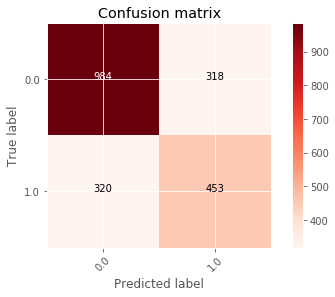

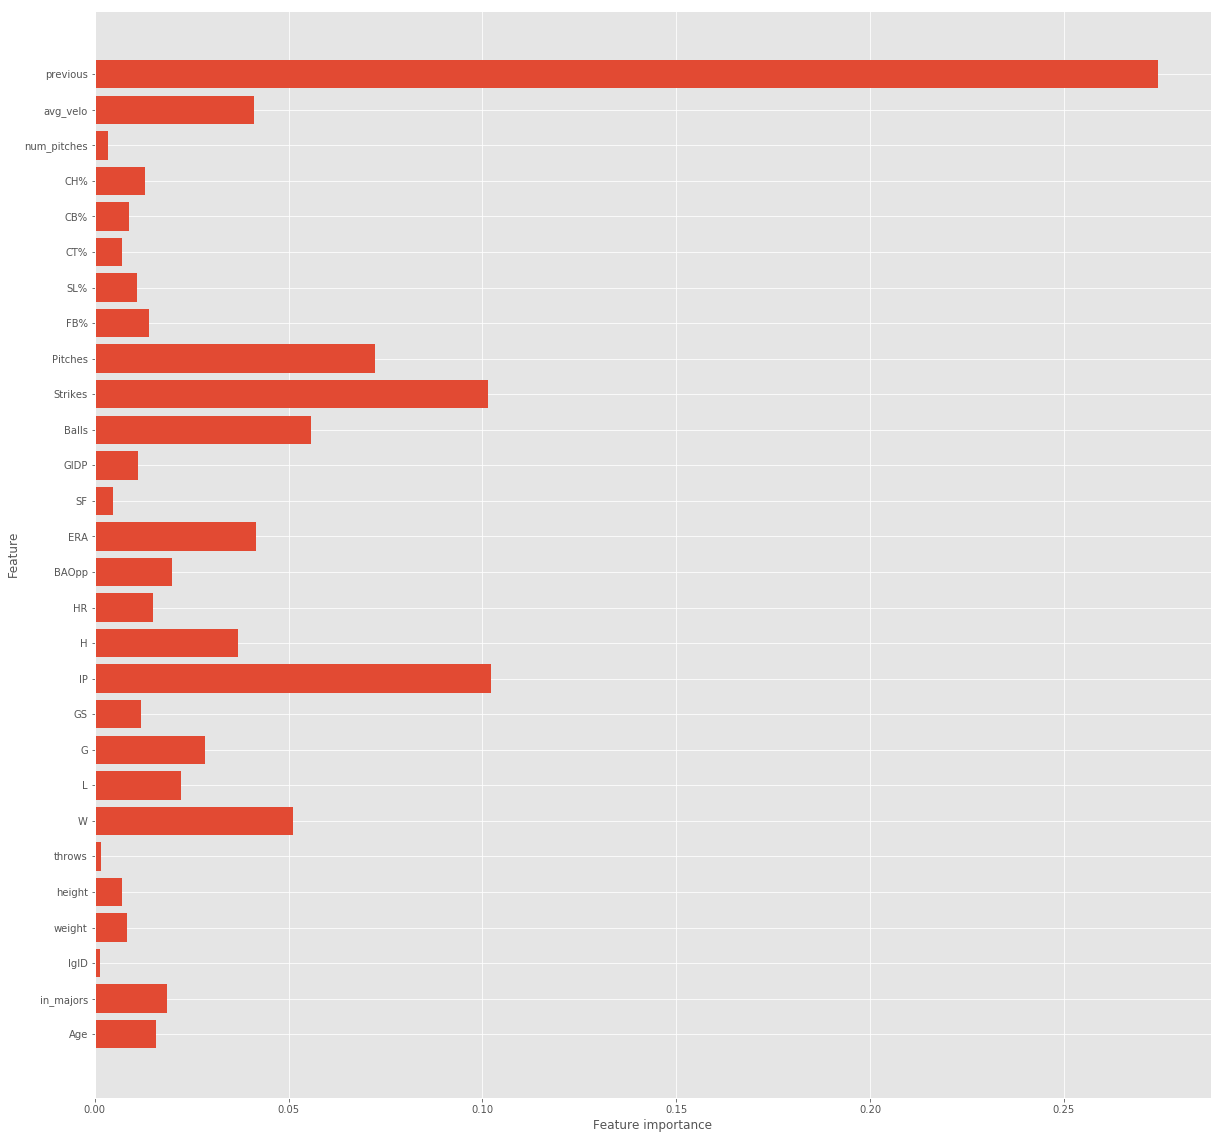

In [23]:
rfmt = rfm.predict(X_test)
rfmtree = metrics.confusion_matrix(i_test, rfmt)
plt.figure()
plot_confusion_matrix(rfmtree, classes=set(inj),
                      title='Confusion matrix')

plt.show()

plot_feature_importances(rfm)

In [34]:
grid_search(RandomForestClassifier(), param_grid2)

Fitting 15 folds for each of 56448000 candidates, totalling 846720000 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.6s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   12.8s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   41.5s
[Parallel(n_jobs=3)]: Done 794 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 1244 tasks      | elapsed:  2.3min
[Parallel(n_jobs=3)]: Done 1794 tasks      | elapsed:  3.2min
[Parallel(n_jobs=3)]: Done 2444 tasks      | elapsed:  4.3min
[Parallel(n_jobs=3)]: Done 3194 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 4044 tasks      | elapsed:  7.2min
[Parallel(n_jobs=3)]: Done 4994 tasks      | elapsed:  8.8min
[Parallel(n_jobs=3)]: Done 6044 tasks      | elapsed: 10.5min
[Parallel(n_jobs=3)]: Done 7194 tasks      | elapsed: 12.4min
[Parallel(n_jobs=3)]: Done 8444 tasks      | elapsed: 14.3min
[Parallel(n_jobs=3)]: Done 9794 tasks      | elapsed: 16.3min
[Parallel(n_jobs=3)]: Done 11244 tasks      | elapsed: 18.8min
[Parallel(n_jobs=3)]: Done 12794 tasks      | elapsed: 21.6min
[Parallel(

KeyboardInterrupt: 

In [96]:
rf = RandomForestClassifier()
rf.fit(X_train, i_train)

prediction, bias, contributions = ti.predict(rf, X_test)

# SMOTE
To even out the injuries with the non-injuries (bec more pitchers don't get injures

In [26]:
smote = SMOTE(ratio = 1.0)
X_train_sm, i_train_sm = sm.fit_sample(X_train, i_train)

/Users/arihorwitz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


# Naive Bayes

In [28]:
#using multinomial (no negatives)
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train, i_train)
mnb_preds = mnb_clf.predict(X_test)
mnb_testing_accuracy = accuracy_score(i_test, mnb_preds)
mnb_testing_accuracy

0.651566265060241

In [29]:
#with SMOTE applied
mnbsm_clf = MultinomialNB()
mnbsm_clf.fit(X_train_sm, i_train_sm)
mnbsm_preds = mnbsm_clf.predict(X_test)
mnbsm_testing_accuracy = accuracy_score(i_test, mnbsm_preds)
mnbsm_testing_accuracy

0.6602409638554216

In [30]:
#Gaussian
gnb_clf = GaussianNB()
gnb_clf.fit(X_train, i_train)
gnb_preds = mnb_clf.predict(X_test)
gnb_testing_accuracy = accuracy_score(i_test, gnb_preds)
gnb_testing_accuracy

0.651566265060241

In [31]:
#with SMOTE applied
gnbsm_clf = GaussianNB()
gnbsm_clf.fit(X_train_sm, i_train_sm)
gnbsm_preds = mnbsm_clf.predict(X_test)
gnbsm_testing_accuracy = accuracy_score(i_test, gnbsm_preds)
gnbsm_testing_accuracy

0.6602409638554216

In [32]:
tree_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 10) 
dt = tree_clf.fit(X_train, i_train)
dt_sm = tree_clf.fit(X_train_sm, i_train_sm)

In [33]:
print(dt.score(X_train, i_train))
dt.score(X_test, i_test)

0.7773187357983887


0.6385542168674698

In [34]:
print(dt_sm.score(X_train_sm, i_train_sm))
dt_sm.score(X_test, i_test)

0.8142952571810287


0.6385542168674698

accuracy................. 0.6386
precision................ 0.5107
recall................... 0.7128
F1....................... 0.5950


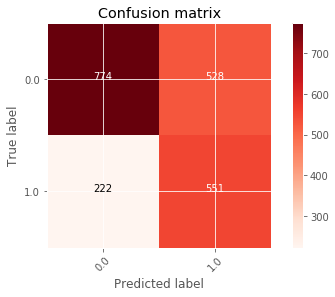

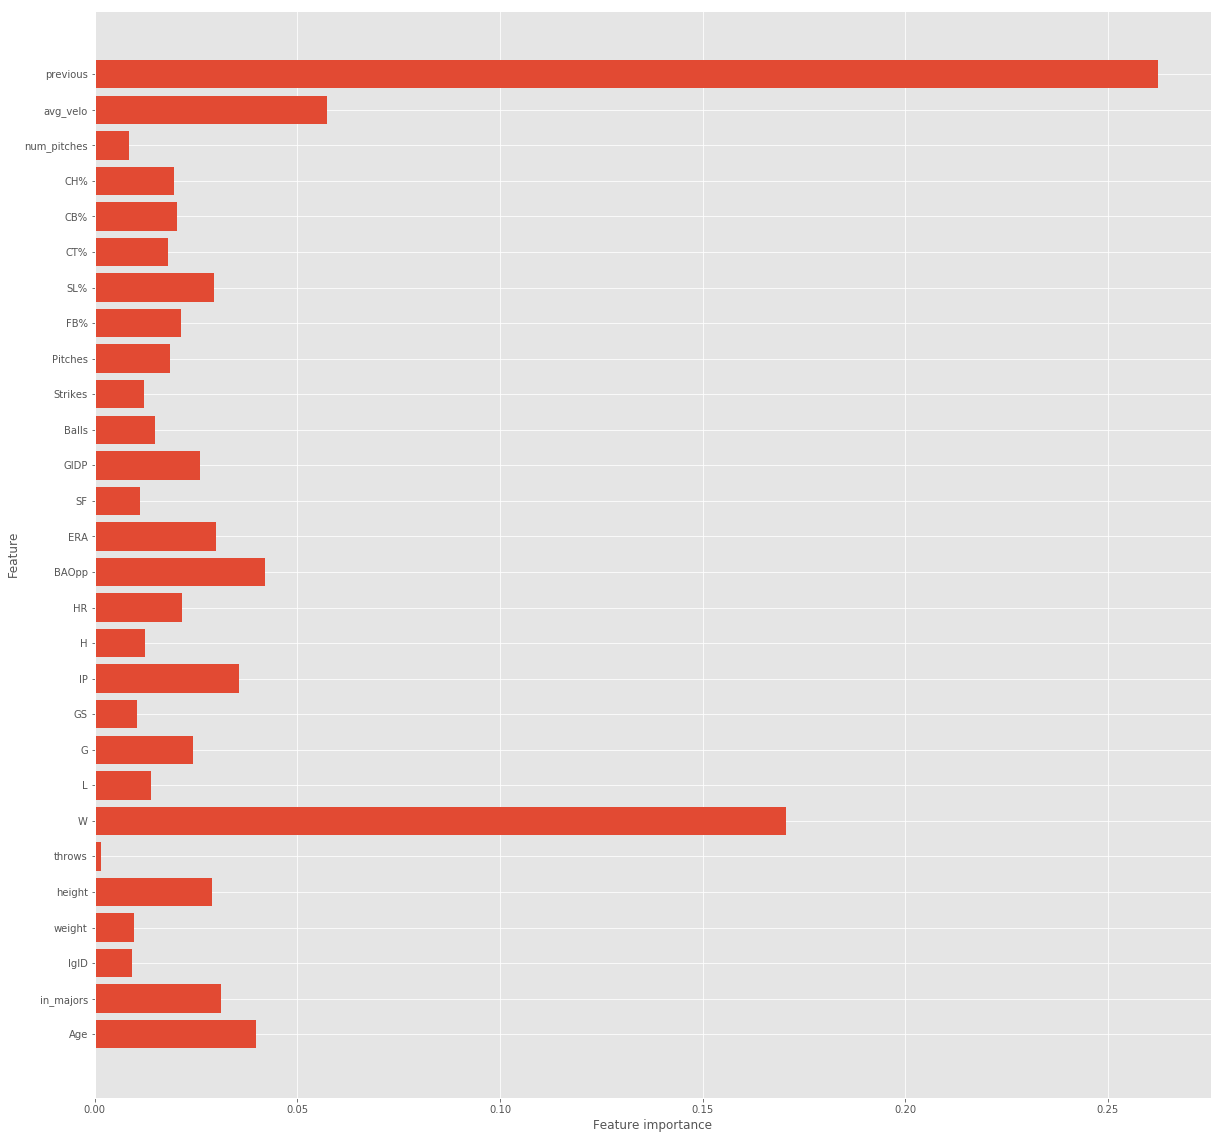

In [35]:
rfsmpred= dt_sm.predict(X_test)
rfsmtree_cm = metrics.confusion_matrix(i_test, rfsmpred)
plt.figure()
plot_confusion_matrix(rfsmtree_cm, classes=set(inj),
                      title='Confusion matrix')

plt.show()

plot_feature_importances(dt_sm)

In [36]:
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
sm_rf = clf_rf.fit(X_train_sm, i_train_sm)

In [39]:
print(sm_rf.score(X_train_sm, i_train_sm))
sm_rf .score(X_test, i_test)

0.9996659986639946


0.687710843373494

accuracy................. 0.6877
precision................ 0.5724
recall................... 0.6391
F1....................... 0.6039


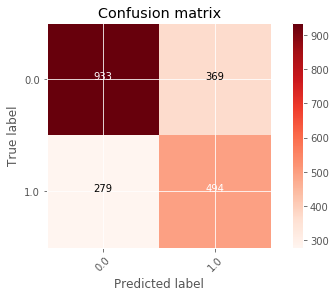

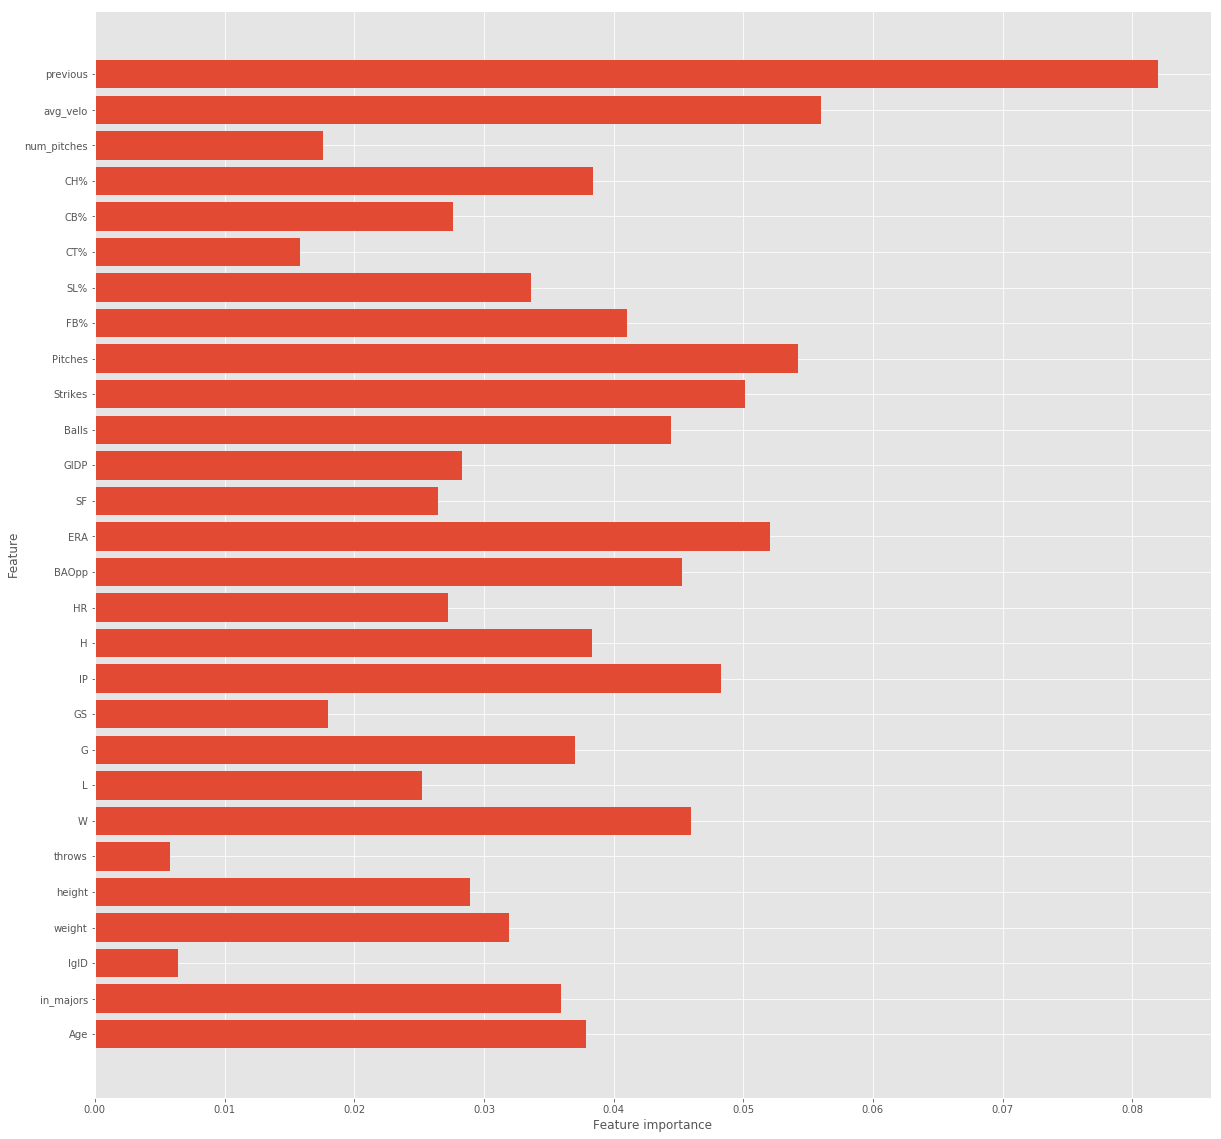

In [40]:
# RF with smote
rfsmpred= sm_rf.predict(X_test)
rfsmtree_cm = metrics.confusion_matrix(i_test, rfsmpred)
plt.figure()
plot_confusion_matrix(rfsmtree_cm, classes=set(inj),
                      title='Confusion matrix')

plt.show()

plot_feature_importances(sm_rf)

# Logistic Regression

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.6s finished



best_model:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.7394892522798043


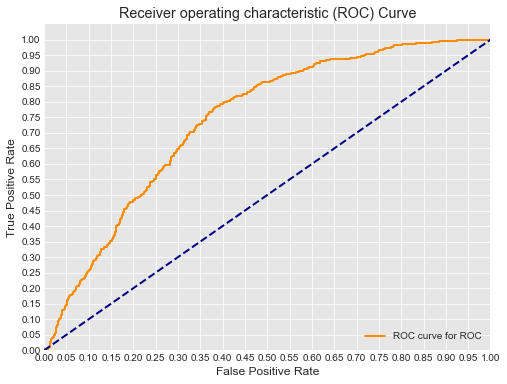


Classification report:
              precision    recall  f1-score   support

        0.0       0.83      0.53      0.65      2994
        1.0       0.52      0.83      0.64      1847

avg / total       0.71      0.64      0.64      4841



(LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=3,
        param_grid={'C': [0.001, 0.01]}, pre_dispatch='2*n_jobs',
        refit=True, return_train_score='warn', scoring='roc_auc', verbose=1),
 array([[0.50969268, 0.49030732],
        [0.30427636, 0.69572364],
        [0.72498365, 0.27501635],
        ...,
     

In [50]:
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.1min finished



best_model:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=40,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Feature Importances: None
AUC: 0.6377983268846212


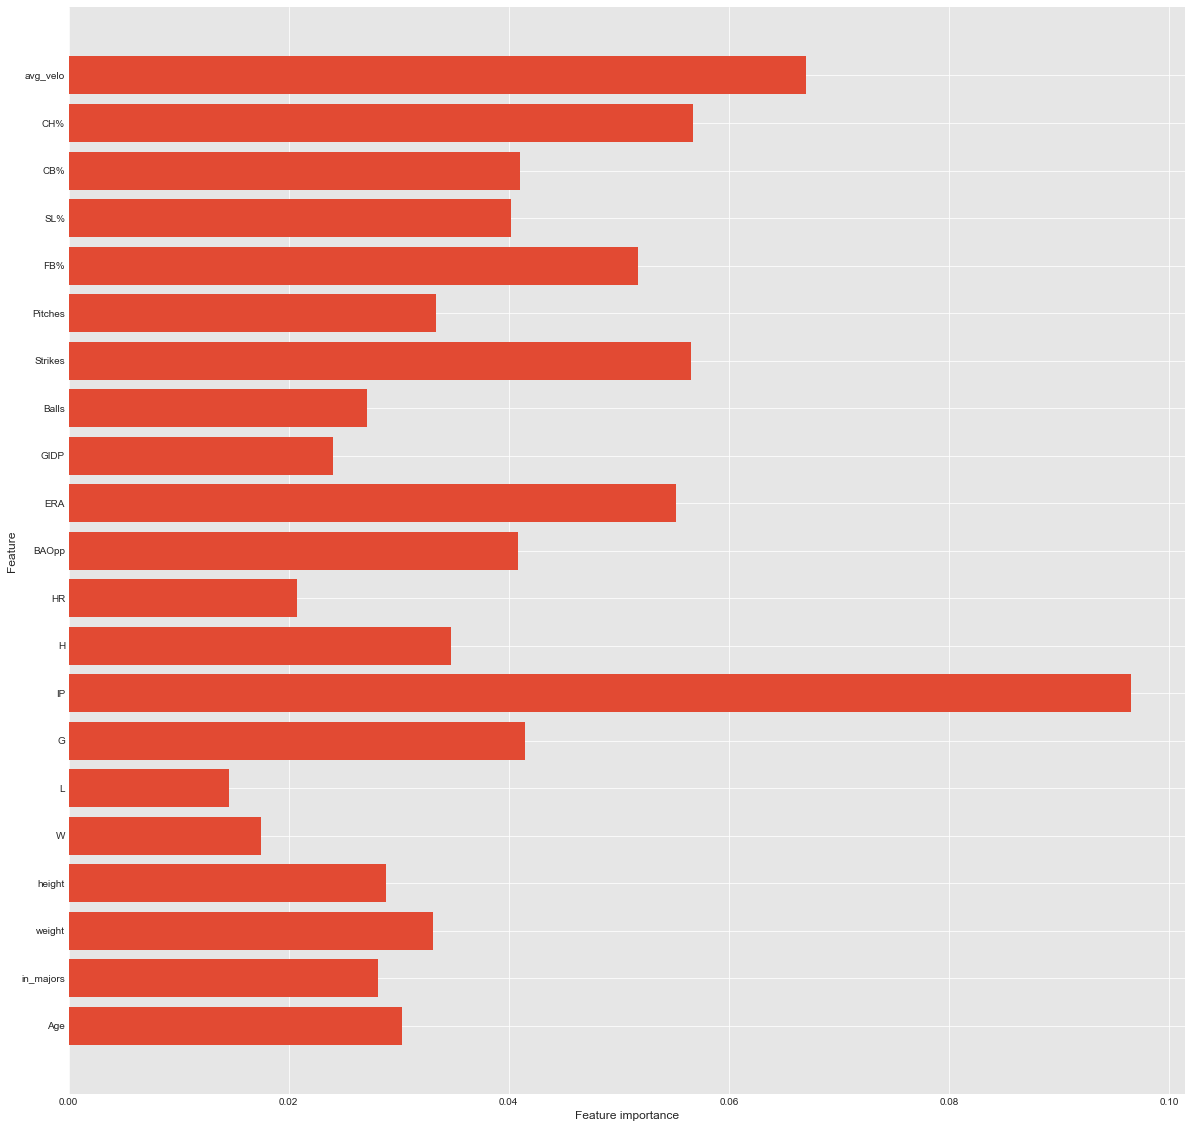

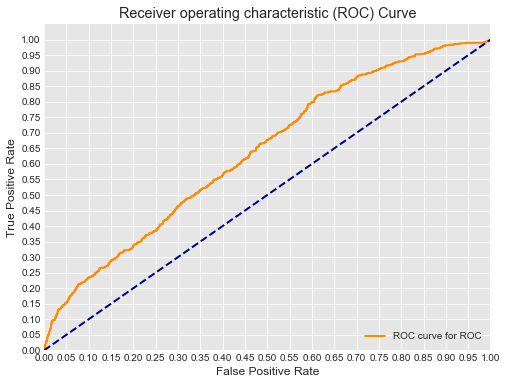


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      3009
        1.0       1.00      1.00      1.00      1832

avg / total       1.00      1.00      1.00      4841



(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=40,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
           

In [173]:
grid_search(GradientBoostingClassifier(), param_grid3)

Fitting 15 folds for each of 16 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    2.4s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:    7.1s finished



best_model:
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.001, n_estimators=2, random_state=None)

Feature Importances: None
AUC: 0.6303477782215837


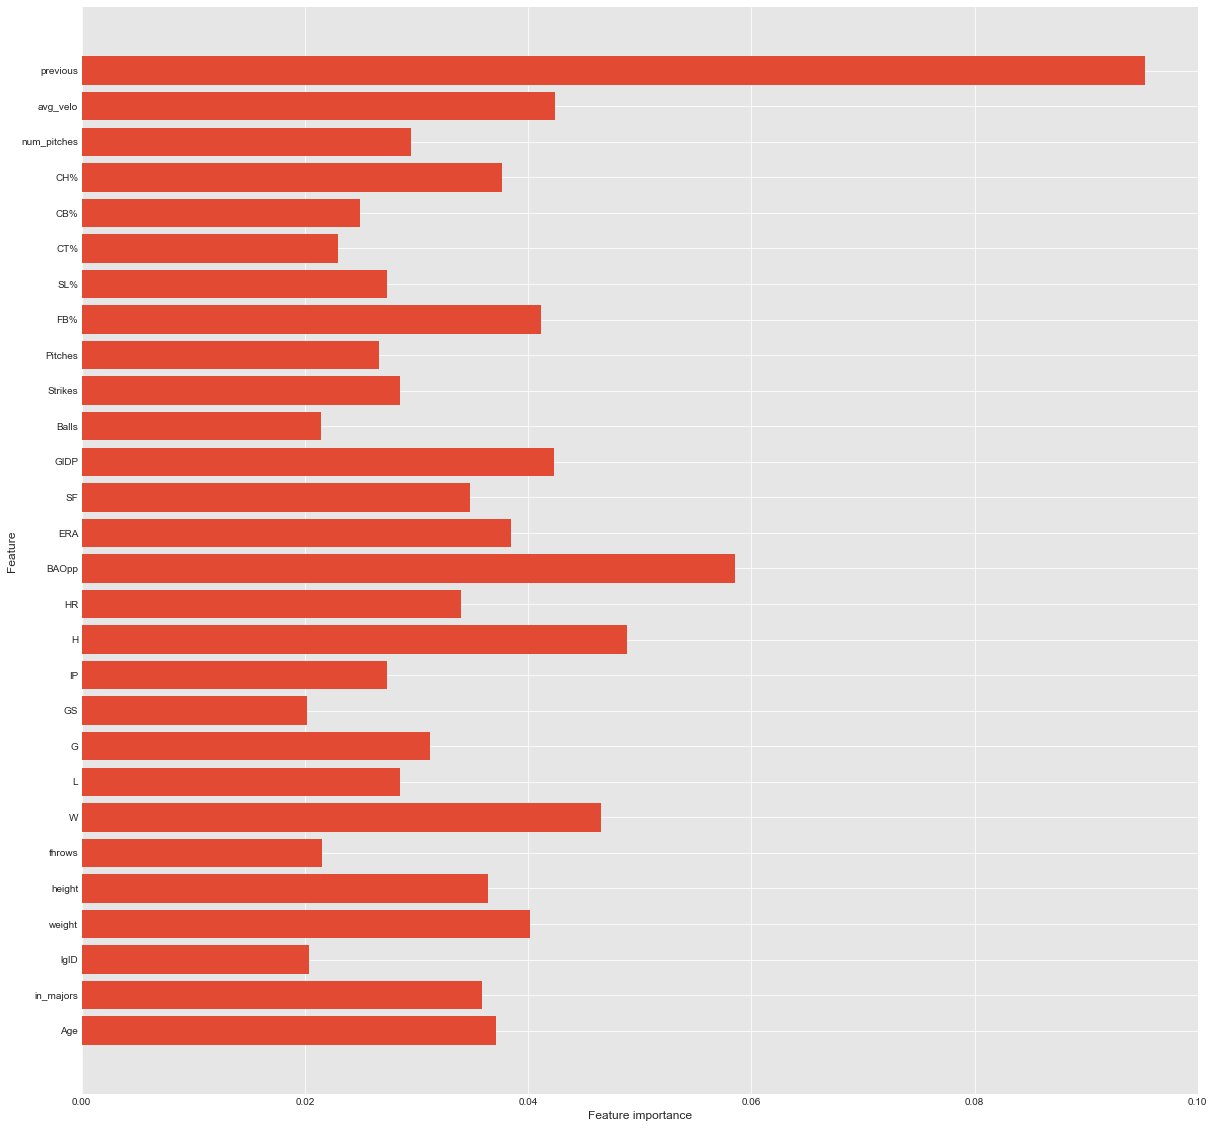

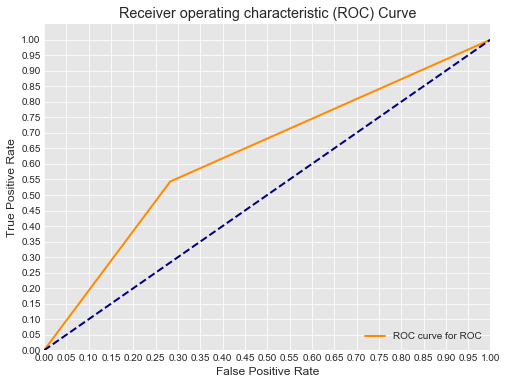


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2994
        1.0       1.00      1.00      1.00      1847

avg / total       1.00      1.00      1.00      4841



(AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'),
           learning_rate=0.001, n_estimators=2, random_state=None),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=

In [53]:
grid_search(AdaBoostClassifier(base_estimator= DecisionTreeClassifier()), param_grid5)

# SVC

In [58]:
svc_clf = SVC(kernel='rbf')
svc = svc_clf.fit(X_train, i_train)
svcsm = svc_clf.fit(X_train_sm, i_train_sm)

In [59]:
print(svc.score(X_train, i_train))
svc.score(X_test, i_test)

0.6238380499896715


0.6236144578313253

In [60]:
print(svcsm.score(X_train_sm, i_train_sm))
svcsm.score(X_test, i_test)

0.6673346693386774


0.6236144578313253

AUC: 0.7478732092928979


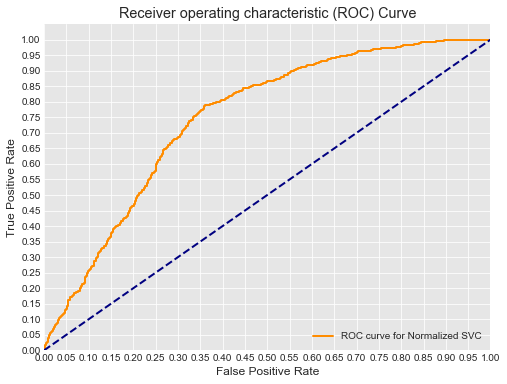

In [62]:
y_hat_train = svc.predict(X_train)

y_score = svc.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(i_test, y_score)
plot_roc_curve(fpr, tpr, "Normalized SVC")

AUC: 0.7478732092928979


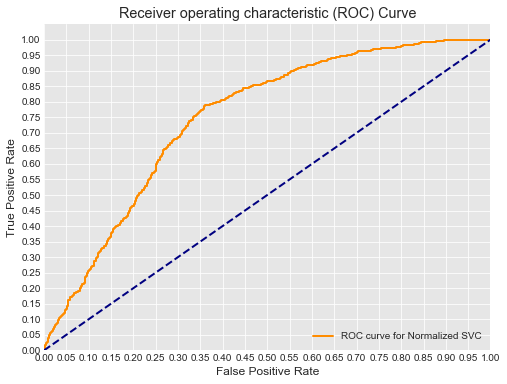

In [64]:
y_hat_train = svcsm.predict(X_train_sm)

y_score = svcsm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(i_test, y_score)
plot_roc_curve(fpr, tpr, "Normalized SVC")

# MLP

In [83]:
def model_chart(model, ep):
    model.history
    epochs = [i for i in range(1, ep+1)]
    plt.figure()
    plt.plot(epochs, model.history['val_acc'])
    plt.plot(epochs, model.history['acc'])
    plt.title("Model Accuracy by Epoch")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Epoch")
    plt.legend(["val_acc", "acc"], loc=4)
    plt.show()

In [110]:
y_train = keras.utils.to_categorical(i_train, 2)
y_test = keras.utils.to_categorical(i_test, 2)

In [92]:
X_train.T.reshape()

(28, 4841)

In [340]:

model = Sequential()
model.add(Dense(25, activation='relu', input_shape=(28, )))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [341]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 25)                725       
_________________________________________________________________
dense_26 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_27 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 52        
Total params: 3,352
Trainable params: 3,352
Non-trainable params: 0
_________________________________________________________________


In [94]:
model = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Train on 4841 samples, validate on 2075 samples
Epoch 1/50
4841/4841 [==============================] - 2s 352us/step - loss: 0.6128 - acc: 0.6534 - val_loss: 0.5907 - val_acc: 0.6540
Epoch 2/50
4841/4841 [==============================] - 1s 153us/step - loss: 0.5817 - acc: 0.6709 - val_loss: 0.5715 - val_acc: 0.6834
Epoch 3/50
4841/4841 [==============================] - 1s 150us/step - loss: 0.5728 - acc: 0.6788 - val_loss: 0.5730 - val_acc: 0.6920
Epoch 4/50
4841/4841 [==============================] - 1s 166us/step - loss: 0.5703 - acc: 0.6821 - val_loss: 0.5701 - val_acc: 0.6882
Epoch 5/50
4841/4841 [==============================] - 1s 163us/step - loss: 0.5699 - acc: 0.6747 - val_loss: 0.5676 - val_acc: 0.6872
Epoch 6/50
4841/4841 [==============================] - 1s 158us/step - loss: 0.5644 - acc: 0.6895 - val_loss: 0.5707 - val_acc: 0.6790
Epoch 7/50
4841/4841 [==============================] - 1s 173us/step - loss: 0.5642 - acc: 0.6852 - val_loss: 0.5634 - val_acc: 0.6916


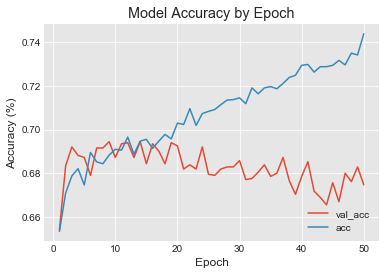

In [95]:
model_chart(model, 50)

# PCA

In [41]:
scaled_df = StandardScaler().fit_transform(pitchers)

In [42]:
pca = PCA(.90)
pca_df = pca.fit_transform(scaled_df)

In [43]:
importance= np.cumsum(pca.explained_variance_ratio_)
len(importance)

14

In [44]:
train_inj = pca.transform(X_train)
test_inj = pca.transform(X_test)

In [45]:
lrm = LogisticRegression(fit_intercept = False, C = 1e12)
lrm.fit(train_inj, i_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [46]:
print(lrm.predict(test_inj))
print(lrm.score(train_inj, i_train))
lrm.score(test_inj, i_test)

[0. 1. 0. ... 1. 1. 1.]
0.6740342904358604


0.683855421686747

In [47]:
pca = PCA(.95)
pca_df = pca.fit_transform(scaled_df)
importance= np.cumsum(pca.explained_variance_ratio_)
len(importance)

17

accuracy................. 0.6839
precision................ 0.5796
recall................... 0.5511
F1....................... 0.5650


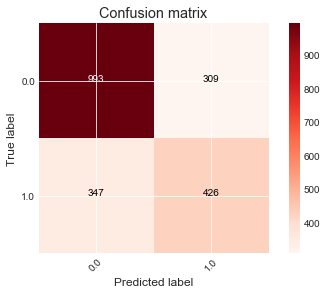

In [56]:
lrmpred= lrm.predict(test_inj)
lrmp = metrics.confusion_matrix(i_test, lrmpred)
plt.figure()
plot_confusion_matrix(lrmp, classes=set(inj),
                      title='Confusion matrix')

plt.show()


### More feature removal

In [176]:
#removing weaker ones and previous bec it overhsadows
pitch = pitchers.drop(columns = ['previous', 'throws', 'GS', 'num_pitches', 'lgID', 'CT%', 'SF'])

In [143]:
pitch

,Age,in_majors,weight,height,W,L,G,IP,H,HR,...,ERA,GIDP,Balls,Strikes,Pitches,FB%,SL%,CB%,CH%,avg_velo
0,0.266667,0.192308,0.37500,0.529412,0.125000,0.315789,0.791209,0.283267,0.187023,0.086957,...,0.018667,0.055556,0.346910,0.293850,0.321827,0.869,0.076647,0.000000,0.000000,0.947320
1,0.433333,0.115385,0.09375,0.470588,0.000000,0.000000,0.010989,0.023904,0.011450,0.000000,...,0.018148,0.027778,0.037219,0.028094,0.032234,0.547,0.458683,0.000000,0.075350,0.900041
2,0.433333,0.115385,0.09375,0.470588,0.000000,0.000000,0.021978,0.023904,0.026718,0.043478,...,0.171407,0.000000,0.037219,0.028094,0.032234,0.547,0.458683,0.000000,0.075350,0.900041
3,0.266667,0.153846,0.25000,0.352941,0.000000,0.000000,0.274725,0.096414,0.087786,0.043478,...,0.018889,0.083333,0.127107,0.102506,0.114467,0.551,0.088623,0.000000,0.000000,0.927858
4,0.233333,0.038462,0.31250,0.470588,0.416667,0.052632,0.461538,0.334661,0.263359,0.217391,...,0.026222,0.138889,0.291433,0.315869,0.316497,0.430,0.000000,0.246684,0.190527,0.885266
5,0.300000,0.076923,0.37500,0.588235,0.041667,0.052632,0.384615,0.147809,0.171756,0.086957,...,0.032148,0.111111,0.191713,0.148823,0.168782,0.630,0.000000,0.340849,0.121636,0.915936
6,0.366667,0.192308,0.34375,0.647059,0.000000,0.000000,0.395604,0.147410,0.053435,0.021739,...,0.005407,0.000000,0.125702,0.144647,0.142132,0.550,0.000000,0.140584,0.077503,0.908600
7,0.100000,0.038462,0.18750,0.529412,0.000000,0.000000,0.000000,0.023904,0.026718,0.000000,...,0.000000,0.027778,0.025983,0.022779,0.024619,0.612,0.000000,0.311671,0.164693,0.887915
8,0.366667,0.269231,0.43750,0.588235,0.083333,0.105263,0.802198,0.247410,0.160305,0.065217,...,0.012815,0.500000,0.278792,0.214123,0.243909,0.652,0.000000,0.427056,0.026911,0.903200
9,0.233333,0.076923,0.71875,0.647059,0.208333,0.052632,0.340659,0.135857,0.156489,0.130435,...,0.038815,0.083333,0.171348,0.134017,0.151523,0.779,0.142515,0.124668,0.007535,0.909109


In [177]:
X_train, X_test, i_train, i_test = train_test_split(pitch, inj, test_size = .3)

In [178]:
sm = SMOTE(ratio = 1.0)
X_train_sm, i_train_sm = sm.fit_sample(X_train, i_train)

/Users/arihorwitz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [298]:
dt_cl = DecisionTreeClassifier(criterion = "gini", max_depth = 4) 
dtreecl = dt_cl.fit(X_train, i_train)
print(dtreecl.score(X_train, i_train))
print(dtreecl.score(X_test, i_test))

0.6614335881016319
0.6409638554216868


In [299]:
dtreeclsm = dt_cl.fit(X_train_sm, i_train_sm)
print(dtreeclsm.score(X_train_sm, i_train_sm))
print(dtreeclsm.score(X_test, i_test))

0.6575503355704698
0.6293975903614458


In [146]:
scaled_df = StandardScaler().fit_transform(pitch)
pca = PCA(.95)
pca_df = pca.fit_transform(scaled_df)
importance= np.cumsum(pca.explained_variance_ratio_)
len(importance)

13

In [147]:
train_inj = pca.transform(X_train)
test_inj = pca.transform(X_test)

In [148]:
lrm = LogisticRegression(fit_intercept = False, C = 1e12)
lrm.fit(train_inj, i_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [149]:
print(lrm.predict(test_inj))
print(lrm.score(train_inj, i_train))
lrm.score(test_inj, i_test)

[1. 0. 0. ... 1. 1. 0.]
0.6358190456517249


0.6101204819277108

accuracy................. 0.6304
precision................ 0.5411
recall................... 0.2797
F1....................... 0.3687


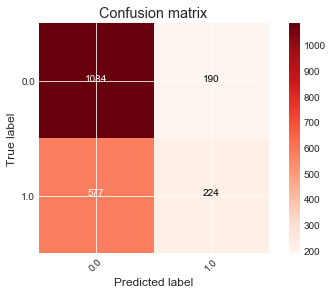

In [75]:
lrmpred= lrm.predict(test_inj)
lrmp = metrics.confusion_matrix(i_test, lrmpred)
plt.figure()
plot_confusion_matrix(lrmp, classes=set(inj),
                      title='Confusion matrix')

plt.show()

accuracy................. 0.6101
precision................ 0.4768
recall................... 0.2741
F1....................... 0.3481


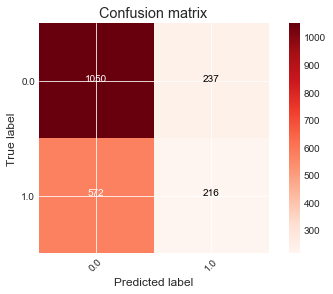

In [150]:
lrmpred= lrm.predict(test_inj)
lrmp = metrics.confusion_matrix(i_test, lrmpred)
plt.figure()
plot_confusion_matrix(lrmp, classes=set(inj),
                      title='Confusion matrix')

plt.show()

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.4s finished



best_model:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.6794514458714274


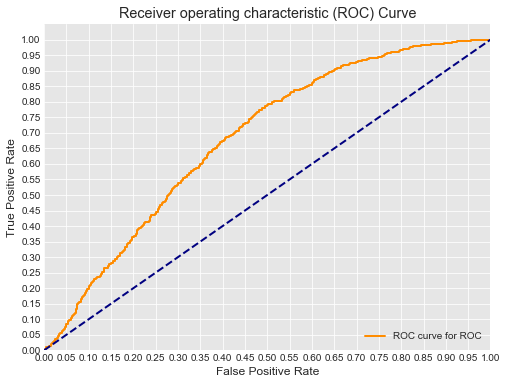


Classification report:
              precision    recall  f1-score   support

        0.0       0.72      0.64      0.68      2980
        1.0       0.51      0.59      0.55      1861

avg / total       0.64      0.62      0.63      4841



(LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=3,
        param_grid={'C': [0.001, 0.01]}, pre_dispatch='2*n_jobs',
        refit=True, return_train_score='warn', scoring='roc_auc', verbose=1),
 array([[0.52407128, 0.47592872],
        [0.47808017, 0.52191983],
        [0.59812176, 0.40187824],
        ...,
     

In [188]:
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.4s finished



best_model:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.6800411275434403


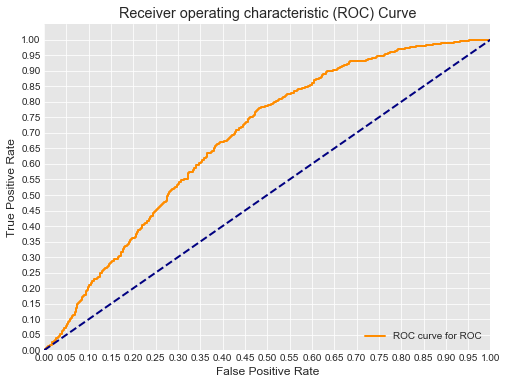


Classification report:
              precision    recall  f1-score   support

        0.0       0.61      0.65      0.63      2980
        1.0       0.63      0.59      0.61      2980

avg / total       0.62      0.62      0.62      5960



(LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=3,
        param_grid={'C': [0.001, 0.01]}, pre_dispatch='2*n_jobs',
        refit=True, return_train_score='warn', scoring='roc_auc', verbose=1),
 array([[0.5241886 , 0.4758114 ],
        [0.47879488, 0.52120512],
        [0.60217372, 0.39782628],
        ...,
     

In [185]:
#with SMOTE
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)

Fitting 15 folds for each of 2 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.4s finished



best_model:
 LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
AUC: 0.6756085897337903


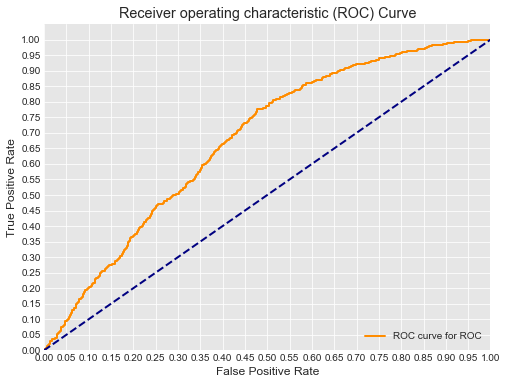


Classification report:
              precision    recall  f1-score   support

        0.0       0.73      0.64      0.68      3022
        1.0       0.50      0.60      0.55      1819

avg / total       0.65      0.63      0.63      4841



(LogisticRegression(C=0.01, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
        fit_params=None, iid=True, n_jobs=3,
        param_grid={'C': [0.001, 0.01]}, pre_dispatch='2*n_jobs',
        refit=True, return_train_score='warn', scoring='roc_auc', verbose=1),
 array([[0.58272508, 0.41727492],
        [0.31318762, 0.68681238],
        [0.47596859, 0.52403141],
        ...,
     

In [77]:
grid_search(LogisticRegression(class_weight = 'balanced'), param_grid1)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.1min finished



best_model:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=40,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Feature Importances: None
AUC: 0.6676828413646175


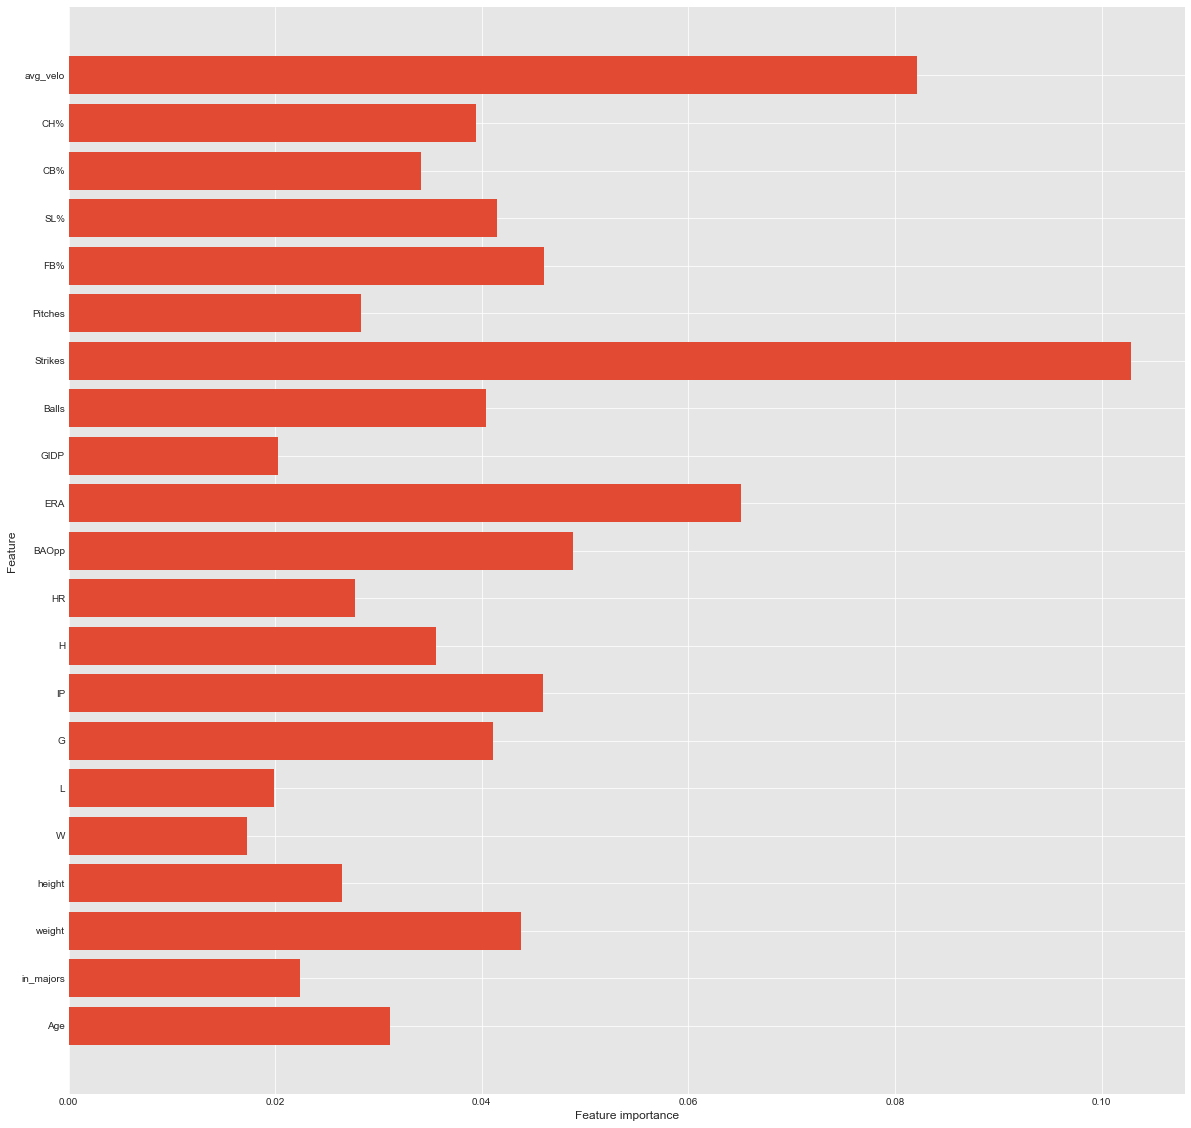

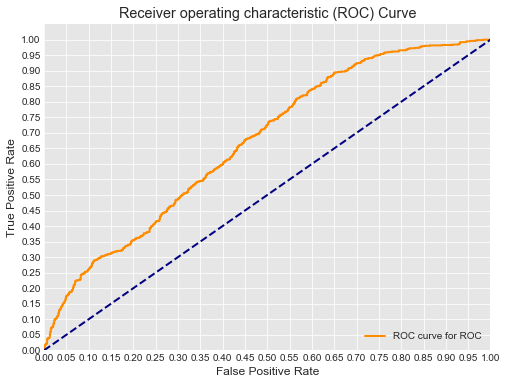


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2980
        1.0       1.00      1.00      1.00      1861

avg / total       1.00      1.00      1.00      4841



(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=40,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
           

In [179]:
grid_search(GradientBoostingClassifier(), param_grid3)

Fitting 15 folds for each of 1 candidates, totalling 15 fits


[Parallel(n_jobs=3)]: Done  15 out of  15 | elapsed:  1.5min finished



best_model:
 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=40,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

Feature Importances: None
AUC: 0.6644581135792977


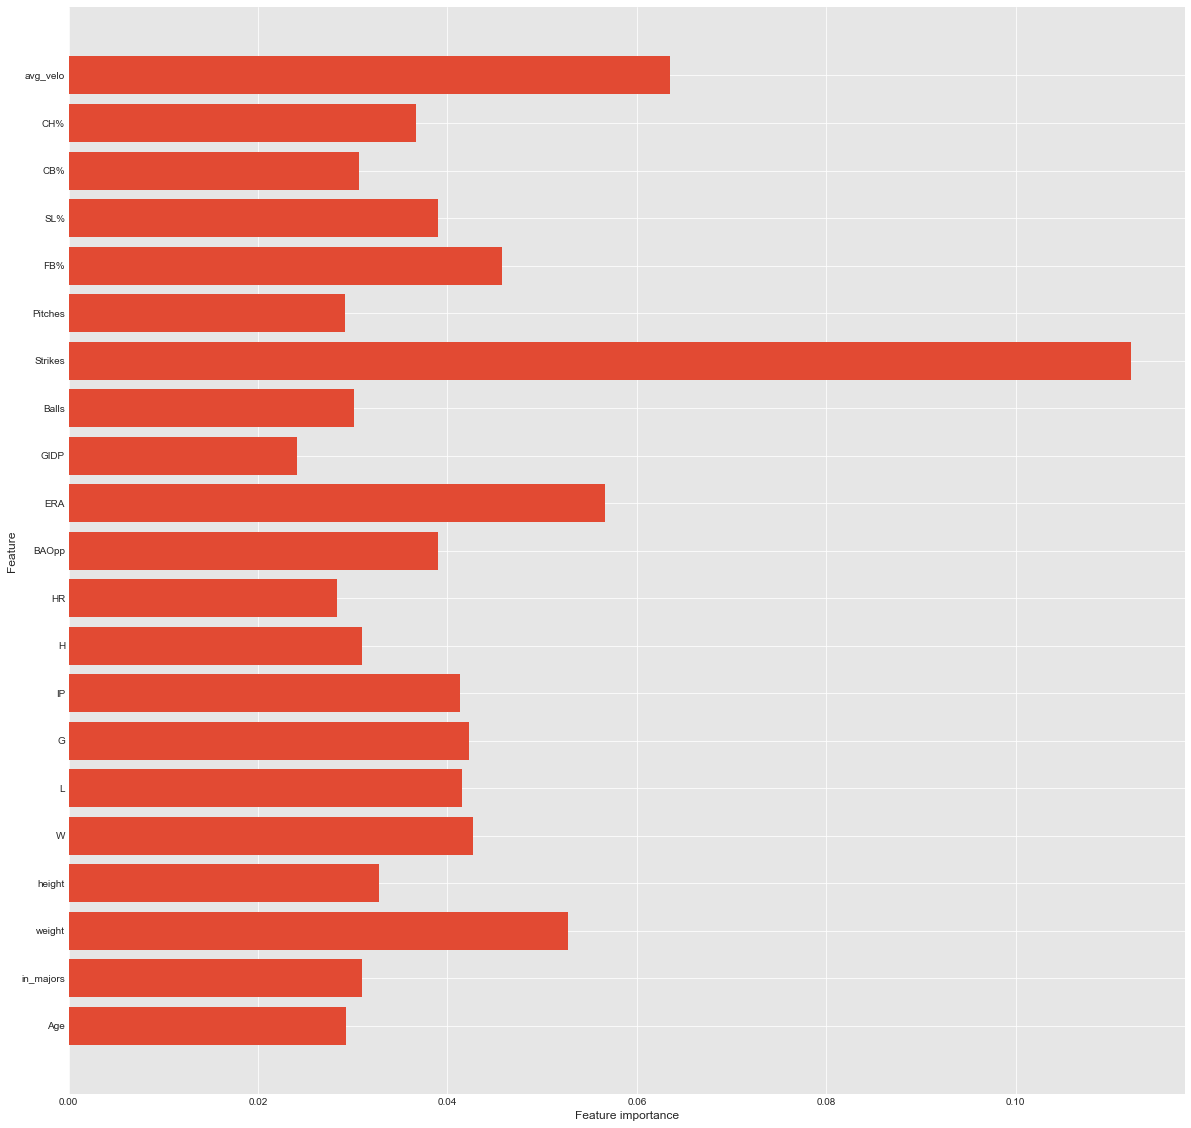

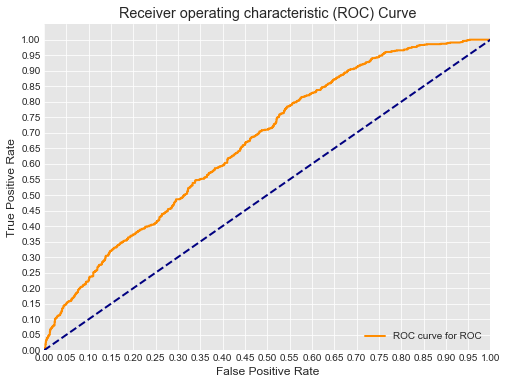


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2980
        1.0       1.00      1.00      1.00      2980

avg / total       1.00      1.00      1.00      5960



(GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=40,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
           

In [182]:
# with SMOTE
grid_search(GradientBoostingClassifier(), param_grid3)

Fitting 15 folds for each of 16 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.2s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:    7.0s finished



best_model:
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.01, n_estimators=2, random_state=None)

Feature Importances: None
AUC: 0.6144703276988198


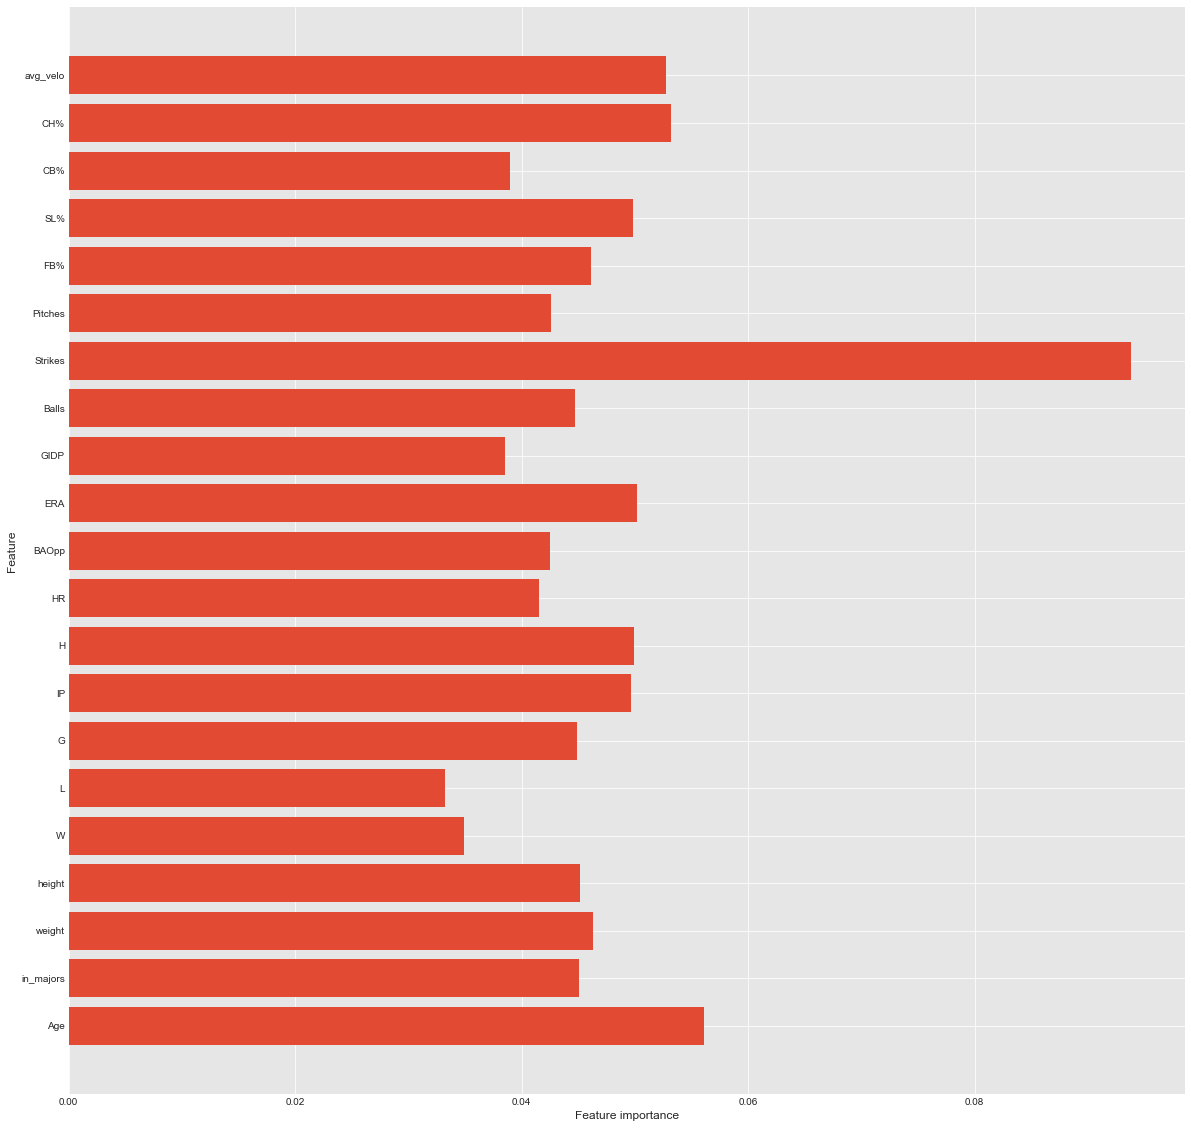

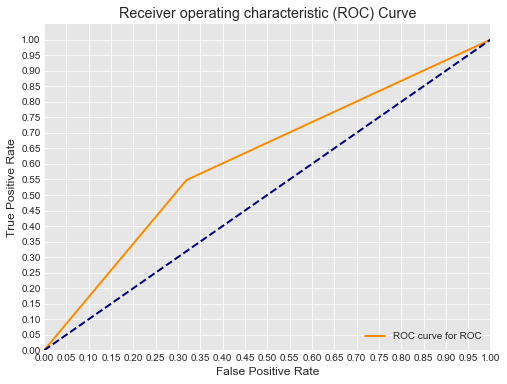


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2980
        1.0       1.00      1.00      1.00      1861

avg / total       1.00      1.00      1.00      4841



(AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'),
           learning_rate=0.01, n_estimators=2, random_state=None),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=F

In [180]:
grid_search(AdaBoostClassifier(base_estimator= DecisionTreeClassifier()), param_grid5)

Fitting 15 folds for each of 16 candidates, totalling 240 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    2.9s
[Parallel(n_jobs=3)]: Done 240 out of 240 | elapsed:    8.3s finished



best_model:
 AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='random'),
          learning_rate=0.01, n_estimators=1, random_state=None)

Feature Importances: None
AUC: 0.6067979584399567


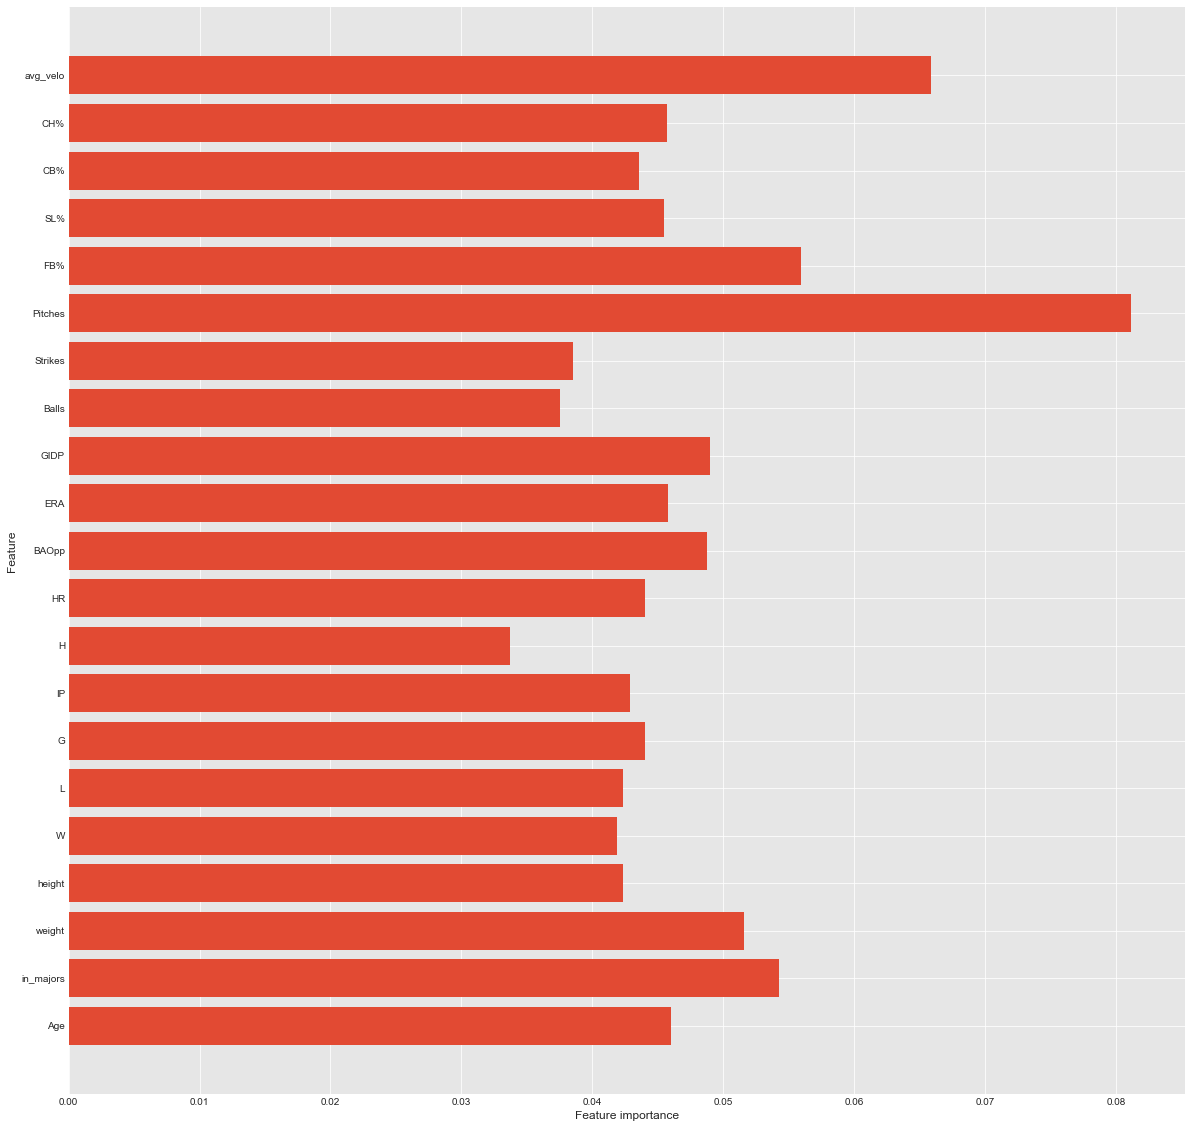

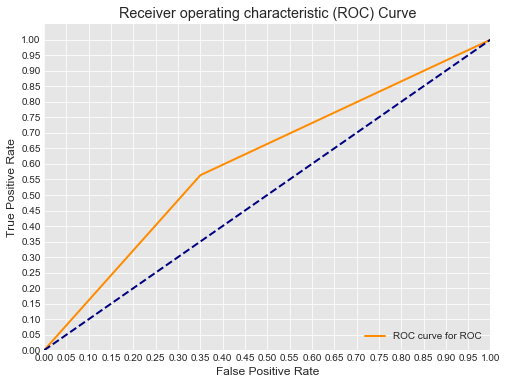


Classification report:
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      2980
        1.0       1.00      1.00      1.00      2980

avg / total       1.00      1.00      1.00      5960



(AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
             splitter='random'),
           learning_rate=0.01, n_estimators=1, random_state=None),
 GridSearchCV(cv=ShuffleSplit(n_splits=15, random_state=2, test_size=0.3, train_size=None),
        error_score='raise',
        estimator=AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=F

In [183]:
# with SMOTE
grid_search(AdaBoostClassifier(base_estimator= DecisionTreeClassifier()), param_grid5)

In [156]:
y_train = keras.utils.to_categorical(i_train, 2)
y_test = keras.utils.to_categorical(i_test, 2)

In [161]:
model2 = Sequential()
model2.add(Dense(25, activation='relu', input_shape=(21, )))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [162]:
model2 = model2.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test))

Train on 4841 samples, validate on 2075 samples
Epoch 1/25
4841/4841 [==============================] - 2s 405us/step - loss: 0.6423 - acc: 0.6197 - val_loss: 0.6371 - val_acc: 0.6178
Epoch 2/25
4841/4841 [==============================] - 1s 164us/step - loss: 0.6105 - acc: 0.6453 - val_loss: 0.6323 - val_acc: 0.6159
Epoch 3/25
4841/4841 [==============================] - 1s 164us/step - loss: 0.6080 - acc: 0.6428 - val_loss: 0.6390 - val_acc: 0.6130
Epoch 4/25
4841/4841 [==============================] - 1s 175us/step - loss: 0.6073 - acc: 0.6523 - val_loss: 0.6455 - val_acc: 0.6058
Epoch 5/25
4841/4841 [==============================] - 1s 221us/step - loss: 0.6053 - acc: 0.6511 - val_loss: 0.6280 - val_acc: 0.6193
Epoch 6/25
4841/4841 [==============================] - 1s 202us/step - loss: 0.6043 - acc: 0.6530 - val_loss: 0.6381 - val_acc: 0.6067
Epoch 7/25
4841/4841 [==============================] - 1s 211us/step - loss: 0.6046 - acc: 0.6470 - val_loss: 0.6296 - val_acc: 0.6202


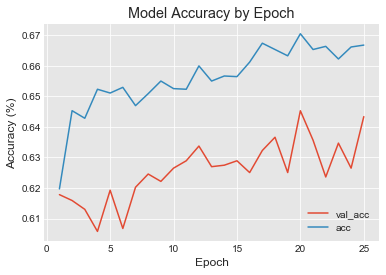

In [163]:
model_chart(model2, 25)

In [194]:
svc_clf = SVC(kernel='rbf')
svc = svc_clf.fit(X_train, i_train)
svcsm = svc_clf.fit(X_train_sm, i_train_sm)

print('Regular svc train :' + str(svc.score(X_train, i_train)))
print('Regular svc test :' + str(svc.score(X_test, i_test)))

print('Smote svc train :' + str(svcsm.score(X_train_sm, i_train_sm)))
print('Smote svc test :' + str(svcsm.score(X_test, i_test)))


Regular svc train :0.6141293121255939
Regular svc test :0.6250602409638554
Smote svc train :0.6354026845637584
Smote svc test :0.6250602409638554


AUC: 0.6810863358041895


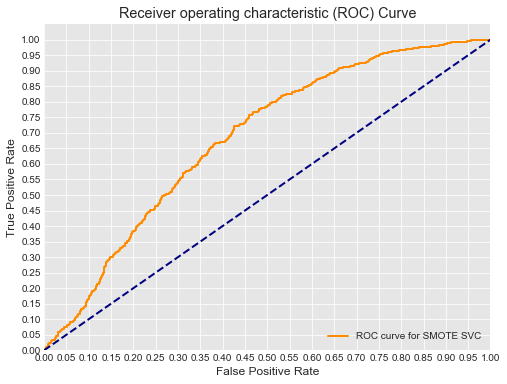

In [195]:
y_hat_train = svcsm.predict(X_train_sm)

y_score = svcsm.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(i_test, y_score)
plot_roc_curve(fpr, tpr, "SMOTE SVC")

AUC: 0.6810863358041895


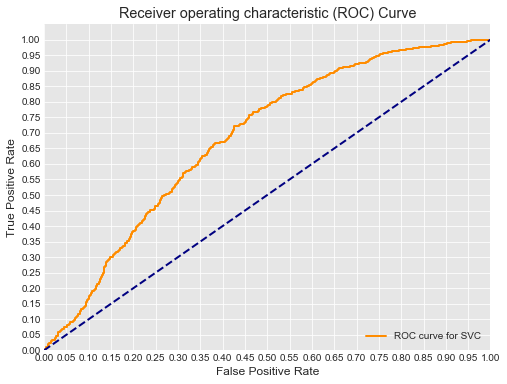

In [196]:
y_hat_train = svc.predict(X_train)

y_score = svc.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(i_test, y_score)
plot_roc_curve(fpr, tpr, "SVC")

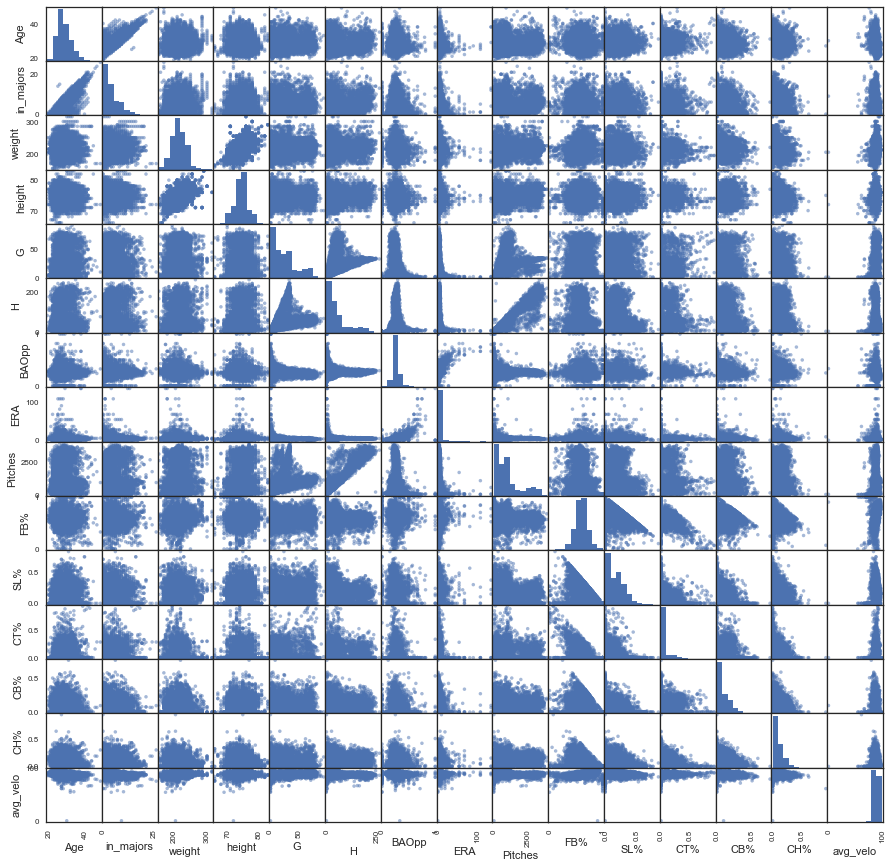

In [321]:
scatter_matrix(df , figsize = (15, 15), diagonal = 'hist')
plt.show()

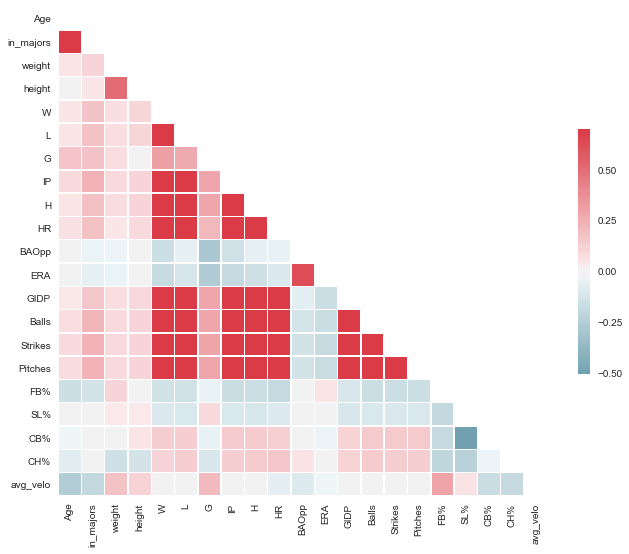

In [211]:
sns.set(style="white")


# Compute the correlation matrix
corr = pitch.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

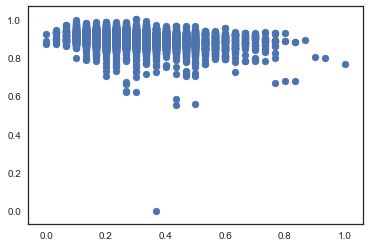

In [214]:
plt.scatter(pitch.Age, pitch.avg_velo)

In [219]:
import statsmodels.api as stm

In [220]:
olssum = stm.OLS(inj, pitch).fit()

In [221]:
olssum.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                injured   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.430
Method:                 Least Squares   F-statistic:                     261.4
Date:                Wed, 03 Oct 2018   Prob (F-statistic):               0.00
Time:                        14:56:37   Log-Likelihood:                -4505.9
No. Observations:                6916   AIC:                             9052.
Df Residuals:                    6896   BIC:                             9189.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.4194      0.081     -5.205      0.000      -0.577      -0.261
in_majors      0.3041      0.072      4.241      0.000       0.164       0.445
weight         0.0546      0.050      1.102      0.270      -0.043       0.152
height         0.1105      0.051      2.172      0.030       0.011       0.210
W              0.1363      0.077      1.769      0.077      -0.015       0.287
L              0.1167      0.071      1.635      0.102      -0.023       0.257
G              0.1975      0.028      7.012      0.000       0.142       0.253
IP            -0.4446      0.379     -1.173      0.241      -1.188       0.299
H             -0.3263      0.129     -2.535      0.011      -0.579      -0.074
HR            -0.0295      0.088     -0.334      0.739      -0.203       0.144
BAOpp         -0.1964      0.093     -2.123      0.034      -0.378      -0.015
ERA           -0.3412      0.165     -2.071      0.038      -0.664      -0.018
GIDP           0.1340      0.086      1.552      0.121      -0.035       0.303
Balls         -0.6139      0.178     -3.457      0.001      -0.962      -0.266
Strikes        1.0196      0.305      3.345      0.001       0.422       1.617
Pitches        0.4597      0.165      2.788      0.005       0.136       0.783
FB%           -0.2070      0.052     -3.985      0.000      -0.309      -0.105
SL%           -0.0661      0.044     -1.502      0.133      -0.152       0.020
CB%           -0.0305      0.055     -0.560      0.576      -0.137       0.076
CH%           -0.1210      0.065     -1.867      0.062      -0.248       0.006
avg_velo       0.5168      0.063      8.268      0.000       0.394       0.639
==============================================================================
Omnibus:                      176.528   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.510
Skew:                           0.406   Prob(JB):                    2.75e-181
Kurtosis:                       1.508   Cond. No.                     2.08e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [222]:
linr = LinearRegression()
line = linr.fit(X_train, i_train)
print(line.score(X_train, i_train))
print(line.score(X_test, i_test))

0.08527254913782967
0.08810672008736853


In [223]:
linesm = linr.fit(X_train_sm, i_train_sm)
print(linesm.score(X_train_sm, i_train_sm))
print(linesm.score(X_test, i_test))

0.09826408898203608
0.028269299734917652


In [252]:
dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 5) 
dtree = dt_clf.fit(X_train, i_train)
dtreesm = dt_clf.fit(X_train_sm, i_train_sm)

In [278]:
print(dtree.score(X_train, i_train))
print(dtree.score(X_test, i_test))

ValueError: Number of features of the model must match the input. Model n_features is 25 and input n_features is 21 

In [277]:
print(dtreesm.score(X_train_sm, i_train_sm))
print(dtreesm.score(X_test, i_test))

0.678020134228188
0.6183132530120482


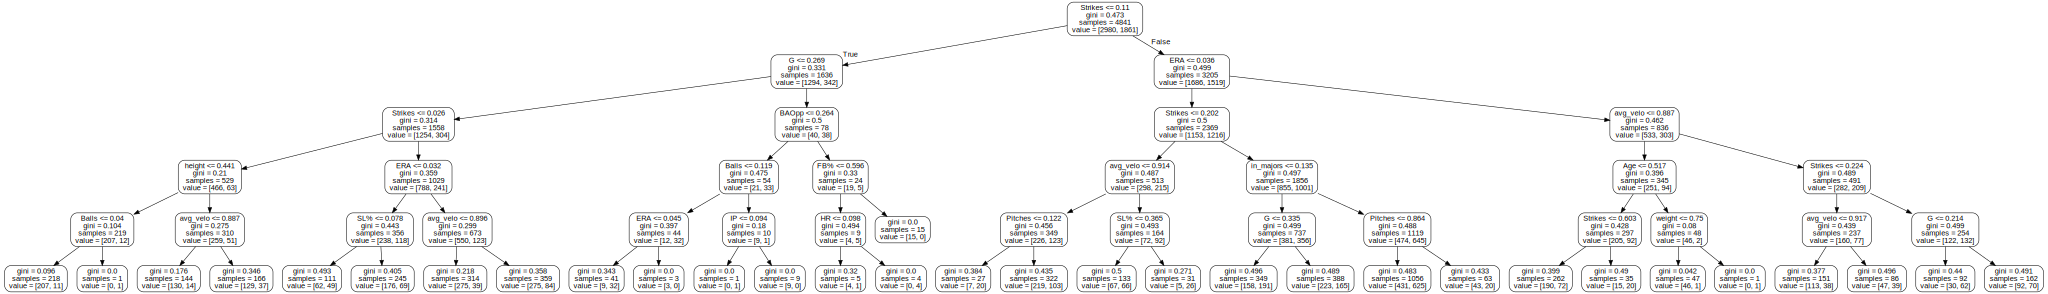

In [251]:

export_graphviz(dtree , out_file="mytree.dot", feature_names=X_train.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

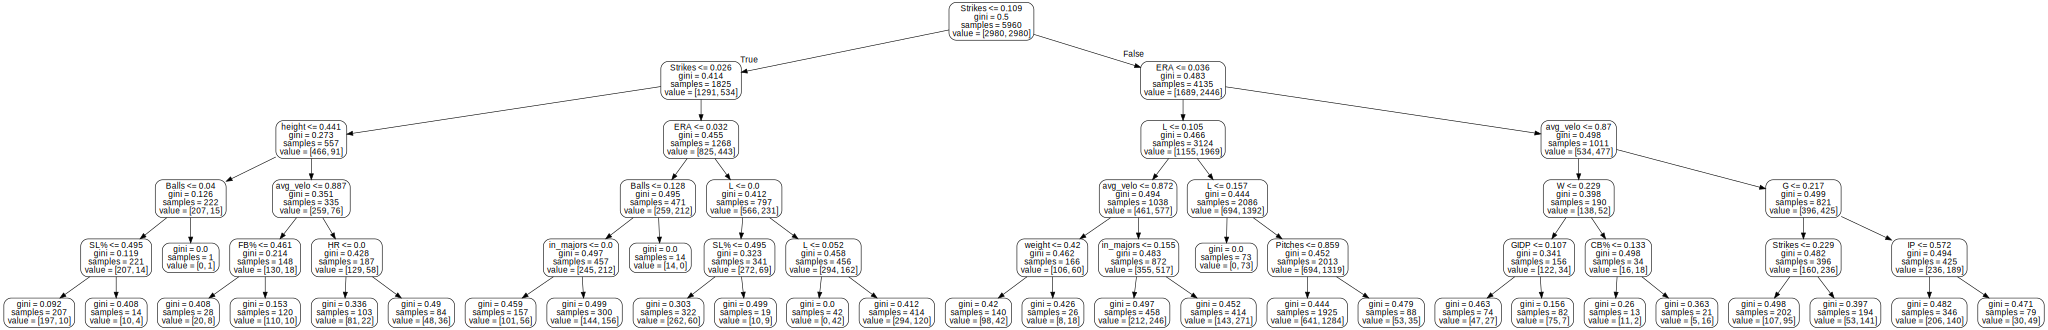

In [253]:
export_graphviz(dtreesm , out_file="mytree.dot", feature_names=X_train.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [268]:
df = pd.read_csv(cwd + ('/cleaned/fixed_complete_list.csv'))

In [269]:
df =df.drop(columns = ['Unnamed: 0', 'Name', 'year','teamID', 'lgID', 'birthYear', 'birthMonth', 'birthDay', 'birthCountry', 'birthState',
       'birthCity', 'bats', 'throws','GS','IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH',
       'CG', 'SHO', 'SV', 'IPouts', 'ER', 'BB', 'SO', 'FBv', 'SLv', 'CTv',
       'CBv', 'CHv', 'SF%', 'SFv', 'KN%', 'KNv', 'XX%','W', 'L'])

In [272]:
inj_df = df.injured
df.drop(columns= ["injured"], axis=1, inplace=True)
df.replace({'no' : 0, 'yes' : 1, 'NL': 0, 'AL':1, 'R':0, 'L': 1}, inplace=True)
X_traindf, X_testdf, i_traindf, i_testdf = train_test_split(df, inj_df, test_size = .3)


In [275]:
dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 4) 
dtree = dt_clf.fit(X_traindf, i_traindf)

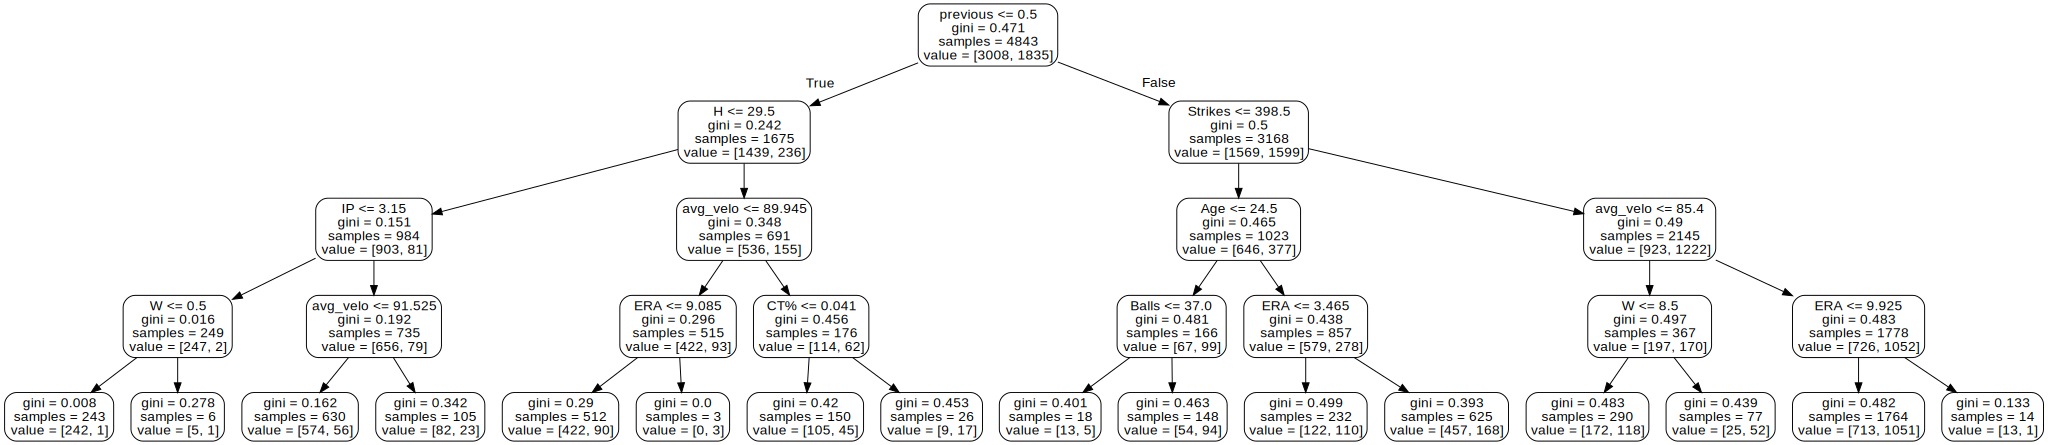

In [276]:
export_graphviz(dtree , out_file="mytree.dot", feature_names=X_traindf.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [289]:
df =df.drop(columns = ['HR','SF', 'GIDP','Balls', 'Strikes','num_pitches','previous' ])

In [290]:
X_traindf, X_testdf, i_traindf, i_testdf = train_test_split(df, inj_df, test_size = .3)

In [291]:
dt_clf = DecisionTreeClassifier(criterion = "gini", max_depth = 4) 
dtree = dt_clf.fit(X_traindf, i_traindf)


In [292]:
print(dtree.score(X_traindf, i_traindf))
print(dtree.score(X_testdf, i_testdf))

0.6712781333883956
0.6421001926782274


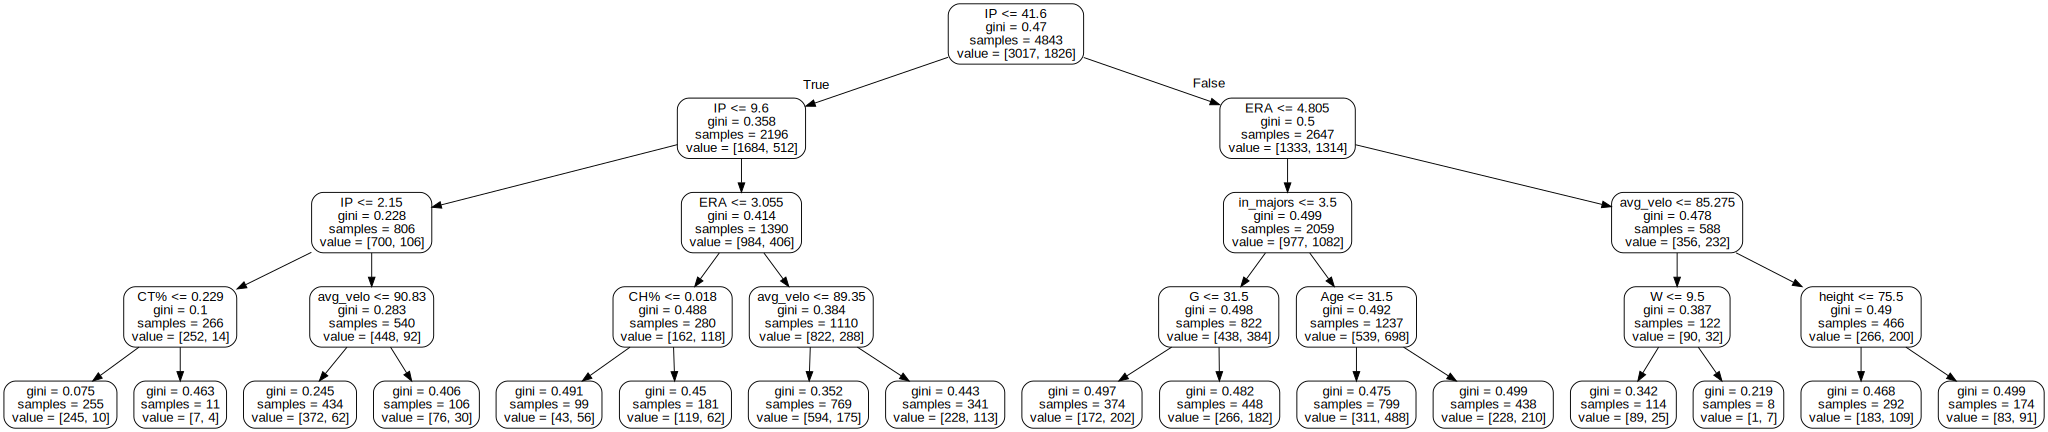

In [293]:
export_graphviz(dtree , out_file="mytree.dot", feature_names=X_traindf.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [294]:
dfsm = SMOTE(ratio = 1.0)
X_train_dfsm, i_train_dfsm = dfsm.fit_sample(X_traindf, i_traindf)

/Users/arihorwitz/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [296]:
dtreedfsm = dt_clf.fit(X_traindf, i_traindf)
print(dtreedfsm.score(X_train_dfsm, i_train_dfsm))
print(dtreedfsm.score(X_testdf, i_testdf))

0.6300961219754724
0.6421001926782274


In [307]:
print(dtree.score(X_traindf, i_traindf))
print(dtree.score(X_testdf, i_testdf))

0.6712781333883956
0.6421001926782274


In [306]:
#SMOTE
print(dtreedfsm.score(X_train_dfsm, i_train_dfsm))
print(dtreedfsm.score(X_testdf, i_testdf))

0.6300961219754724
0.6421001926782274


In [305]:
rfmdf = RandomForestClassifier(n_estimators=250, max_depth=5, min_samples_split=10)
rfmdf_model = rfmdf.fit(X_traindf, i_traindf)
rfmdfsm_model = rfmdf.fit(X_train_dfsm, i_train_dfsm)

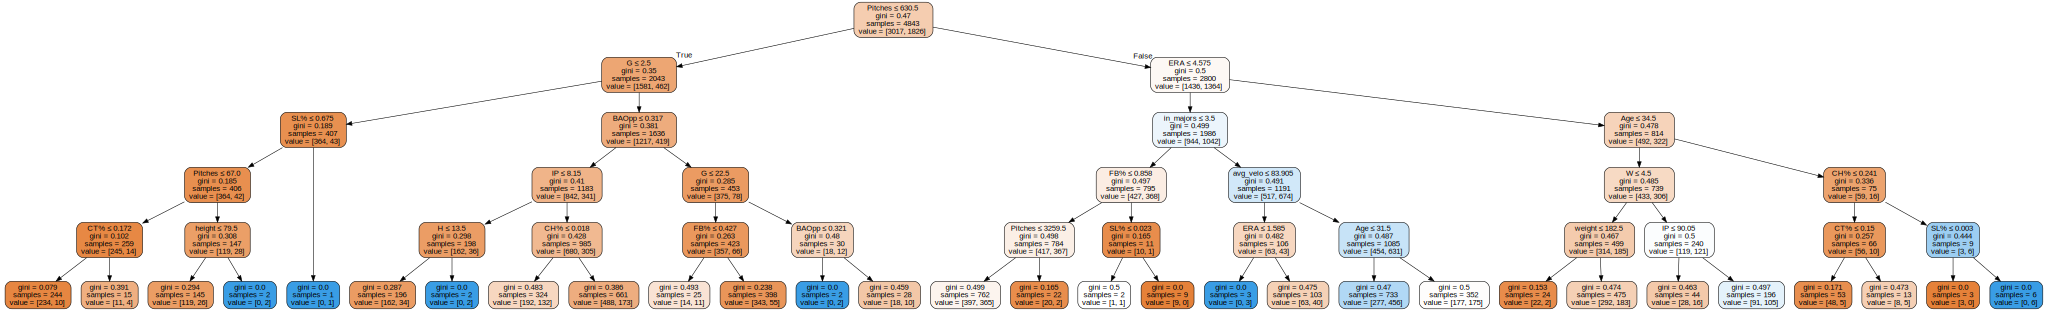

In [338]:
tree_2 = rfmdf_model.estimators_[1].fit(X_traindf, i_traindf)
export_graphviz(tree_2, out_file="mytree.dot", feature_names=X_traindf.columns, rounded=True, leaves_parallel=True, special_characters=True , filled=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
export_graphviz(dtree , out_file="mytree.dot", feature_names=X_traindf.columns , rounded=True)
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

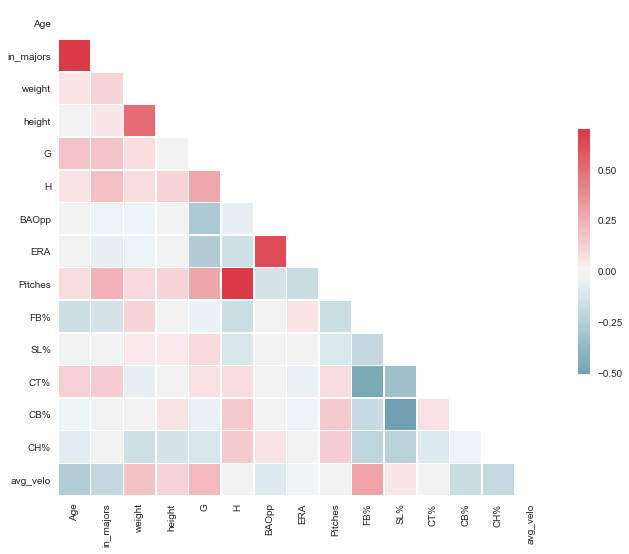

In [329]:
sns.set(style="white")


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

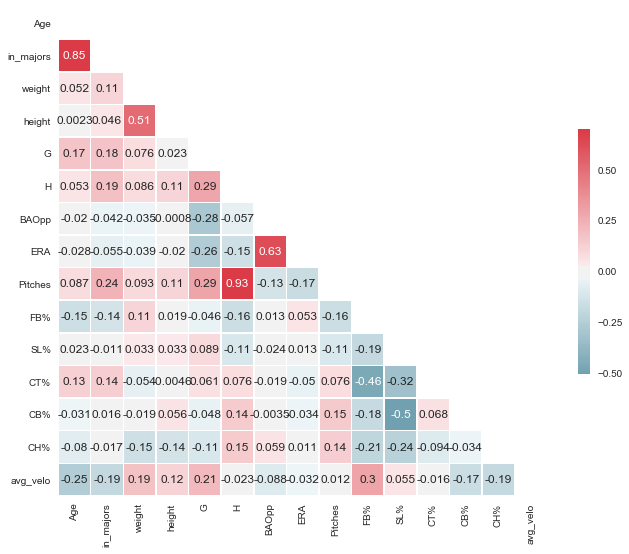

In [328]:
sns.set(style="white")


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot= True, cmap=cmap, vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [318]:
df.drop(columns = 'IP', inplace = True)

In [319]:
df.head()

,Age,in_majors,weight,height,G,H,BAOpp,ERA,Pitches,FB%,SL%,CT%,CB%,CH%,avg_velo
0,27,5,215.0,75.0,73.0,49.0,0.190,2.52,1269,0.869,0.064,0.000,0.000,0.000,92.97
1,32,3,170.0,74.0,2.0,3.0,0.231,2.45,128,0.547,0.383,0.000,0.000,0.070,88.33
2,32,3,170.0,74.0,3.0,7.0,0.500,23.14,128,0.547,0.383,0.000,0.000,0.070,88.33
3,27,4,195.0,72.0,26.0,23.0,0.267,2.55,452,0.551,0.074,0.261,0.000,0.000,91.06
4,26,1,205.0,74.0,43.0,69.0,0.220,3.54,1248,0.430,0.000,0.208,0.186,0.177,86.88


In [322]:
df.describe()

,Age,in_majors,weight,height,G,H,BAOpp,ERA,Pitches,FB%,SL%,CT%,CB%,CH%,avg_velo
count,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000,6919.000000
mean,28.077323,4.271137,214.358144,74.479694,25.923255,56.189478,0.266078,5.194742,1038.215494,0.597177,0.162249,0.047314,0.082863,0.091566,87.826731
std,3.977598,4.009770,21.487407,2.195191,20.929859,56.566338,0.082328,6.043592,951.315601,0.130338,0.140350,0.111125,0.097595,0.090072,3.616212
min,19.000000,0.000000,155.000000,66.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1.000000,200.000000,73.000000,8.000000,14.000000,0.228000,3.085000,302.000000,0.525000,0.001000,0.000000,0.000000,0.010000,86.030000
50%,27.000000,3.000000,215.000000,75.000000,21.000000,37.000000,0.258000,4.180000,814.000000,0.601000,0.157000,0.000000,0.051000,0.071000,88.070000
75%,30.000000,7.000000,225.000000,76.000000,35.000000,71.000000,0.294000,5.660000,1283.500000,0.672500,0.254000,0.000000,0.143000,0.145000,90.070000
max,49.000000,26.000000,315.000000,83.000000,92.000000,262.000000,1.000000,135.000000,3941.000000,1.000000,0.835000,0.934000,0.754000,0.929000,98.140000
